In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from string import ascii_uppercase

plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.format": "pdf",
    "lines.linewidth": 2,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    'axes.labelweight': 'bold',
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "grid.alpha": 0.5,
    "font.family": "DejaVu Sans",  # 更稳定跨平台字体
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": False,
    "text.antialiased": True
})

# 1、使用PPT算法规范化

In [2]:
def normalize_evidence(evidence_list):
    """
    归一化证据，使所有证据具有相同的事件键 {'A', 'B', 'C'}
    - 输入: evidence_list (列表), 包含多个证据体，每个证据体是一个字典，键为元组，值为概率。
    - 输出: 归一化后的证据列表，每个证据体具有相同的事件键 {'A', 'B', 'C'}。
    """
    all_hypotheses = {'A', 'B', 'C'}  # 确保所有证据具有相同的键
    normalized = []

    for ev in evidence_list:
        new_ev = {h: 0 for h in all_hypotheses}  # 初始化为 0
        for key, prob in ev.items():
            for h in key:  # 元组键可能包含多个事件
                new_ev[h] += prob / len(key)  # 平均分配概率
        normalized.append(new_ev)

    return normalized

# 2、距离公式

## 2.1 bhattacharyya距离公式

In [4]:
def bhattacharyya_distance(p, q):
    """
    计算 Bhattacharyya 距离
    - 输入: p, q (列表或数组), 两个概率分布。
    - 输出: Bhattacharyya 距离，用于衡量两个概率分布之间的相似性。
    """
    p, q = np.array(p), np.array(q)
    return -np.log(np.sum(np.sqrt(p * q)) + 1e-10)  # 避免 log(0)

## 2.2 计算两个焦元之间的 Jaccard 相似度

In [3]:
def jaccard_similarity(A, B):
    """
    计算两个焦元之间的 Jaccard 相似度
    """
    if not A and not B:  # 处理空集情况
        return 1.0
    intersection = len(A.intersection(B))
    union = len(A.union(B))
    return intersection / union if union > 0 else 0.0

def build_jaccard_matrix(focal_elements):
    """
    构建 Jaccard 相似度矩阵 D
    """
    n = len(focal_elements)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):  # 只计算上三角，减少重复计算
            sim = jaccard_similarity(focal_elements[i], focal_elements[j])
            D[i, j] = D[j, i] = sim  # 矩阵对称
    return D

def jousselme_distance(m1, m2):
    """
    计算 Jousselme 距离
    """
    focal_elements = list(set(m1.keys()).union(set(m2.keys())))  # 取并集
    focal_elements = [frozenset(f) for f in focal_elements]

    D = build_jaccard_matrix(focal_elements)  # 计算 Jaccard 矩阵

    m1_vec = np.array([m1.get(f, 0) for f in focal_elements])
    m2_vec = np.array([m2.get(f, 0) for f in focal_elements])

    diff = m1_vec - m2_vec
    distance = np.sqrt(0.5 * np.dot(diff.T, np.dot(D, diff)))
    return distance

def jousselme_similarity(evidence, method="inverse_quadratic", sigma=1.0):
    """
    计算 Jousselme 相似度
    method 可选：
    - "inverse"（默认）：1 / (1 + d)
    - "inverse_quadratic"：1 / (1 + d²)（增强区分度）
    - "logarithmic"：1 / (1 + log(1 + d))
    - "gaussian"：exp(-d² / sigma²)（模拟高斯核）
    """
    evidence_frozenset = [{frozenset(k): v for k, v in ev.items()} for ev in evidence]
    distance = jousselme_distance(evidence_frozenset[0], evidence_frozenset[1])

    if method == "inverse":
        return 1 / (1 + distance)
    elif method == "inverse_quadratic":
        return 1 / (1 + distance**2)
    elif method == "logarithmic":
        return 1 / (1 + np.log1p(distance))
    elif method == "gaussian":
        return np.exp(-distance**2 / (2 * sigma**2))
    elif method == "exponential":
        return max(0, (1 - distance))
    elif method == "quadratic":
        return np.exp(-1.5*distance)
    else:
        raise ValueError("Unsupported method. Choose from: 'inverse', 'inverse_quadratic', 'logarithmic', 'gaussian'.")

## 2.3 余旋相似度

In [6]:
def cosine_similarity(p, q):
    """
    计算余弦相似度
    - 输入: p, q (字典), 两个证据体的焦元及其概率。
    - 输出: 余弦相似度。
    """
    keys = set(p.keys()).union(set(q.keys()))
    vec_p = np.array([p.get(key, 0) for key in keys])
    vec_q = np.array([q.get(key, 0) for key in keys])
    return np.dot(vec_p, vec_q) / (np.linalg.norm(vec_p) * np.linalg.norm(vec_q) + 1e-8)

## 2.4 KL散度距离

In [7]:
def kl_divergence(p, q):
    """
    计算 KL 散度
    - 输入: p, q (字典), 两个证据体的焦元及其概率。
    - 输出: KL 散度。
    """
    keys = set(p.keys()).union(set(q.keys()))
    p = np.array([p.get(key, 0) for key in keys])
    q = np.array([q.get(key, 0) for key in keys])
    return np.sum(p * np.log(p / q + 1e-8))

## 2.5 JS散度距离

In [8]:
def js_divergence(p, q):
    """
    计算 JS 散度
    - 输入: p, q (字典), 两个证据体的焦元及其概率。
    - 输出: JS 散度。
    """
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

## 2.6 OWA距离公式

In [4]:
def compute_singleton_relation(i, j):
    """
    通用单例元素关系计算
    支持: 字母(A-Z)、数字、或混合输入
    关系公式: 1 - exp(-|a - b|)
    """

    # 字母到数字的自动映射 (A->1, B->2, ..., Z->26)
    def to_numeric(x):
        if isinstance(x, str) and x.isalpha() and x in ascii_uppercase:
            return ascii_uppercase.index(x) + 1
        return int(x)  # 如果是数字字符串或数字

    a = to_numeric(i)
    b = to_numeric(j)
    return 0 if a == b else 1 - np.exp(-abs(a - b))

def compute_singleton_set(A, B, gamma):
    """计算单例到集合的关系"""
    r_values = []
    for b in B:
        r_values.append(compute_singleton_relation(A, b))
    return owa_aggregation(r_values, gamma, force_binary=False)


def build_relation_matrix(focal_elements, gamma=0.8):
    """构建关系矩阵（适配字母型证据体）"""
    n = len(focal_elements)
    R_o = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):  # 仅计算上三角
            A, B = focal_elements[i], focal_elements[j]

            # Case 1: 单例-单例关系
            if len(A) == 1 and len(B) == 1:
                a = next(iter(A))  # 获取集合中的唯一元素
                b = next(iter(B))
                R_o[i, j] = compute_singleton_relation(a, b)

            # Case 2: 单例-集合关系
            elif len(A) == 1 and len(B) > 1:
                a = next(iter(A))
                R_o[i, j] = compute_singleton_set(a, B, gamma)

            # Case 3: 集合-集合关系
            elif len(A) > 1 and len(B) > 1:
                r_values = []
                for a in A:
                    r_values.append(compute_singleton_set(a, B, gamma))
                R_o[i, j] = owa_aggregation(r_values, gamma, force_binary=False)

    # 对称填充下三角
    R_o = np.triu(R_o) + np.triu(R_o, 1).T
    return R_o


def owa_aggregation(values, gamma, force_binary=False):
    """OWA聚合函数（保持不变）"""
    if len(values) == 1:
        return values[0]

    if force_binary:  # 二元情况直接计算
        sorted_v = sorted(values, reverse=True)
        return gamma * sorted_v[0] + (1 - gamma) * sorted_v[1]

    sorted_values = np.array(sorted(values, reverse=True))
    n = len(sorted_values)

    def entropy(w):
        return -np.sum(w * np.log(w + 1e-10))

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.sum([(n - k - 1) / (n - 1) * w[k] for k in range(n)]) - gamma}
    ]
    bounds = [(0.001, 1) for _ in range(n)]
    res = minimize(entropy, x0=np.ones(n) / n, bounds=bounds,
                   constraints=constraints, options={'ftol': 1e-10})

    weights = res.x / np.sum(res.x)
    return np.dot(sorted_values, weights)


def d_OWA(m1, m2, gamma=0.8):
    """计算两个证据体之间的距离"""
    # 获取所有焦元（保持顺序一致性）
    focal_elements = sorted(list(set(m1.keys()).union(set(m2.keys()))), key=lambda x: (len(x), x))

    # 构建关系矩阵
    R_o = build_relation_matrix(focal_elements, gamma)

    # 转换为向量（保持相同顺序）
    m1_vec = np.array([m1.get(f, 0) for f in focal_elements])
    m2_vec = np.array([m2.get(f, 0) for f in focal_elements])

    # 计算距离
    diff = m1_vec - m2_vec
    M = np.eye(len(R_o)) - R_o
    distance = np.sqrt(0.5 * diff.T @ M @ diff)
    return distance


def owa_similarity_matrix(evidence, gamma=0.8):
    """计算证据体列表的相似度矩阵"""
    # 转换证据体格式
    evidence_frozenset = [{frozenset(k): v for k, v in ev.items()} for ev in evidence]

    n = len(evidence_frozenset)
    similarity_matrix = np.eye(n)  # 对角线为1

    for i in range(n):
        for j in range(i + 1, n):
            distance = d_OWA(evidence_frozenset[i], evidence_frozenset[j], gamma)
            similarity = 1 - distance
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity

    return similarity_matrix

# 3、相似度矩阵

## 3.1 基于bhattacharyyade的相似度矩阵

In [9]:
def compute_similarity_matrix(evidence, sigma=1.0):
    """
    计算相似度矩阵 S
    - 输入: evidence (列表), 归一化后的证据列表。
    - 输出: 相似度矩阵 S，表示证据之间的相似性。
    """
    n = len(evidence)
    S = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            p = list(evidence[i].values())
            q = list(evidence[j].values())

            distance = bhattacharyya_distance(p, q)
            similarity = np.exp(distance)  # 转化为相似度
            # similarity = np.exp(-(distance ** 2) / (2 * sigma ** 2))  # 高斯核函数

            S[i, j] = similarity
            S[j, i] = similarity  # 矩阵对称

    return S

## 3.2 基于Jaccard的相似度矩阵

In [5]:
def compute_similarity_matrix_jousselme(evidence, method):
    """
    计算相似度矩阵 S
    - 输入: evidence (列表), 归一化后的证据列表。
    - 输出: 相似度矩阵 S，表示证据之间的相似性。
    """
    n = len(evidence)
    S = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            list_dict = [evidence[i], evidence[j]]
            distance = jousselme_similarity(list_dict,method)

            S[i, j] = distance
            S[j, i] = distance  # 矩阵对称

    return S

## 3.3 余旋相似度矩阵

In [11]:
def compute_similarity_matrix_cos(evidence):
    n = len(evidence)
    S = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            similarity = cosine_similarity(evidence[i], evidence[j])
            S[i, j] = similarity
            S[j, i] = similarity  # 矩阵对称
    return S

## 3.4 JS散度相似度矩阵

In [12]:
def compute_similarity_matrix_JS(evidence):
    n = len(evidence)
    S = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            divergence = js_divergence(evidence[i], evidence[j])
            similarity = np.exp(-divergence)  # 转化为相似度
            S[i, j] = similarity
            S[j, i] = similarity  # 矩阵对称
    return S

# 4、非线性聚合

In [6]:
def nonlinear_aggregation(S, alpha=1.0):
    """
    限制 log-sum-exp 放大效应，避免某些证据占据主导地位
    """
    return np.log(1 + np.sum(np.exp(alpha * S), axis=1)) / alpha

# 5、自适应高斯变换

In [7]:
def adaptive_gaussian_transform(x):
    """
    自适应高斯变换：根据数据的均值和标准差动态调整 mu 和 sigma
    """
    mu = np.mean(x)
    sigma = np.std(x)
    return np.exp(-0.5 * ((x - mu) / (sigma + 1e-8))**2)  # 防止除零

# 6、通过相似度矩阵计算依赖度权重

## 6.1 结合自适应高斯变换的权重计算

In [8]:
def new_compute_weight_from_similarity_gaussian(S, lambda_entropy=0.1, beta=3.5, alpha=1.0):
    S_agg = nonlinear_aggregation(S, alpha)  # 非线性聚合
    S_agg_gaussian = adaptive_gaussian_transform(S_agg)  # 自适应高斯变换
    def objective(w):
        return -np.dot(w, S_agg_gaussian) + lambda_entropy * np.sum(w * np.log(w + 1e-8))

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(S_agg_gaussian)

    w0 = S_agg_gaussian / np.sum(S_agg_gaussian)
    result = minimize(objective, w0, bounds=bounds, constraints=constraints)

    return result.x

## 6.2 计算归一化的可信度权重 Crd

In [9]:
def compute_credibility_from_similarity(S):
    """
    计算归一化的可信度权重 Crd
    - 输入: S (相似度矩阵)
    - 输出: Crd (可信度权重向量)
    """
    # 计算支持度 Sup(m_i)
    Sup = np.sum(S, axis=1) - np.diag(S)  # 去掉自身对自身的支持度

    # 计算可信度 Crd 并归一化
    Crd = Sup / np.sum(Sup) if np.sum(Sup) != 0 else np.ones_like(Sup) / len(Sup)  # 避免除零

    return Crd

## 6.3 一个原始的权重计算

In [10]:
def compute_weight_from_similarity(S):
    """
    计算权重 R：
    - R = 归一化的 S_avg
    - 输入: S (矩阵), 相似度矩阵。
    - 输出: 权重 R，表示每个证据的可靠性。
    """
    S_avg = np.mean(S, axis=1)  # 每行的均值
    S_avg = S_avg ** 5  # 增强高相似度证据源的权重
    R = S_avg / np.sum(S_avg)  # 归一化
    return R

## 6.4 非线性聚合权重计算

In [11]:
def new_compute_weight_from_similarity_nonlinear(S, lambda_entropy=0.1, beta=3.5, alpha=1.0):
    S_agg = nonlinear_aggregation(S, alpha)  # 非线性聚合
    S_agg_sigmoid = 1 / (1 + np.exp(-beta * (S_agg - np.mean(S_agg))))
    def objective(w):
        return -np.dot(w, S_agg_sigmoid) + lambda_entropy * np.sum(w * np.log(w + 1e-8))

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(S_agg_sigmoid)

    w0 = S_agg_sigmoid / np.sum(S_agg_sigmoid)
    # result = minimize(objective, w0, bounds=bounds, constraints=constraints)
    # 优化
    result = minimize(
        objective,
        w0,
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'  # 使用 SLSQP 算法
    )
    return result.x

## 使用 Tsallis 熵正则化

In [9]:
def compute_weight_tsallis(S, q=1.5, lambda_tsallis=0.1):
    """
    使用 Tsallis 熵正则化，使高相似度权重更大，同时避免过度集中。
    """
    S_avg = np.mean(S, axis=1)

    def objective(w):
        tsallis_entropy = lambda_tsallis * (1 - np.sum(w ** q)) / (q - 1)
        return -np.dot(w, S_avg) + tsallis_entropy

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(S_avg)

    w0 = np.ones(len(S_avg)) / len(S_avg)
    result = minimize(objective, w0, bounds=bounds, constraints=constraints)

    return result.x

# 7、软似然估计函数

In [12]:
def soft_likelihood_function(omega, evidence, R_values, alpha):
    """
    软似然函数 (Soft Likelihood Function, SLF)
    - 输入: omega (字符串), 当前假设；evidence (列表), 归一化后的证据列表；R (数组), 权重；alpha (浮点数), 乐观系数。
    - 输出: 软似然值 L，表示当前假设的软似然估计。
    """
    N = len(evidence)
    prob_values = [ev.get(omega, 0) for ev in evidence]
    # R_values = R / np.sum(R)  # 归一化可靠性度

    # 排序索引
    sorted_indices = np.argsort([prob_values[i] * R_values[i] for i in range(N)])[::-1]

    # 计算权重向量
    w = []
    for i in range(N):
        if i == 0:
            w.append(R_values[sorted_indices[i]] ** ((1 - alpha) / alpha))
        else:
            sum_k = np.sum([R_values[sorted_indices[k]] for k in range(i + 1)])
            sum_k_prev = np.sum([R_values[sorted_indices[k]] for k in range(i)])
            w.append(sum_k ** ((1 - alpha) / alpha) - sum_k_prev ** ((1 - alpha) / alpha))

    # 计算软似然值
    L = 0
    for i in range(N):
        prod = 1
        for k in range(i + 1):
            prod *= prob_values[sorted_indices[k]]
        L += w[i] * prod

    return L

# 8、归一化融合

In [13]:
def fuse_evidence(evidence, R, alpha=0.1):
    """
    计算融合概率：
    - 使用软似然函数进行最终的概率估计
    - 输入: evidence (列表), 归一化后的证据列表；R (数组), 权重；alpha (浮点数), 乐观系数。
    - 输出: 融合后的概率分布。
    """
    hypotheses = {'A', 'B', 'C'}
    fused = {}

    for omega in hypotheses:
        L = soft_likelihood_function(omega, evidence, R, alpha)
        fused[omega] = L

    print("fused_result_before_nor:", fused)
    # 归一化
    total_L = sum(fused.values()) + 1e-10
    fused = {k: v / total_L for k, v in fused.items()}

    return fused

# 经典融合算法


In [22]:
def dempster_combine(m1, m2):
    """
    Dempster 组合规则 (DCR)
    - 输入: m1 和 m2 是两个证据体的字典表示。
    - 输出: 融合后的证据体 (字典)。
    """
    hypotheses = set(m1.keys()).union(set(m2.keys()))
    m_combined = {h: 0.0 for h in hypotheses}

    # 计算冲突因子 K
    K = 0.0
    for h1 in m1:
        for h2 in m2:
            if h1 != h2:  # 如果 h1 和 h2 不相同（即冲突）
                K += m1[h1] * m2[h2]

    # 计算组合后的 BPA
    for h1 in m1:
        for h2 in m2:
            if h1 == h2:  # 如果 h1 和 h2 相同（即一致）
                m_combined[h1] += m1[h1] * m2[h2] / (1 - K)

    return m_combined

def fuse_evidence_multiple_times(adjusted_evidence, n):
    """
    多次融合证据 (Step 3-2)
    - 输入: adjusted_evidence (字典), 调整后的证据体。
    - 输入: n (整数), 融合次数。
    - 输出: 最终融合结果 (字典)。
    """
    result = adjusted_evidence
    for _ in range(n - 1):
        result = dempster_combine(result, adjusted_evidence)
    return result

# 一个统一的执行入口

In [36]:
def main_function(evidence):
    # 处理证据体格式
    normalized_evidence = normalize_evidence(evidence)

    # 计算相似度矩阵
    S = compute_similarity_matrix_jousselme(normalized_evidence, "exponential")
    # S = owa_similarity_matrix(evidence)

    # 计算权重 R
    print(S)
    R =new_compute_weight_from_similarity_nonlinear(S)
    R_cre = compute_credibility_from_similarity(S)

    # 乘积融合
    # product = R * R_cre
    # R_fused = product / np.sum(product)
    # R_final = R_fused ** 2 / np.sum(R_fused ** 2)
    # # 指数加权参数
    # beta, gamma = 2.0, 2.0  # 可调整放大效果
    #
    # # 计算指数加权融合
    # W_final = (R ** beta) * (R_cre ** gamma)
    # alpha = 0.8  # 相似度权重占比80%
    # w_fused = alpha * R + (1 - alpha) * R_cre
    # w_fused /= np.sum(w_fused)  # 归一化

    # 相似度引导的乘积融合
    lambda_ = 0.2  # 置信度微调系数
    w_fused = R * (1 + lambda_ * R_cre)
    w_fused /= np.sum(w_fused)  # 归一化

    # 计算融合概率
    alpha = 0.1  # 乐观系数
    fused_probabilities = fuse_evidence(normalized_evidence, w_fused, alpha)
    # fused_probabilities_cre = fuse_evidence(normalized_evidence, R_cre, alpha)

    print("Optimal R:", R)
    print("Optimal R_fused:", w_fused)
    print("Fused probabilities (after SLF):", fused_probabilities)
    # print("Optimal R_cre:", R_cre)
    # print("Fused probabilities (after SLF_cre):", fused_probabilities_cre)
    # Step 3-2: 多次融合证据
    # fused_result_after_slf_cre =dempster_combine(fused_probabilities,fused_probabilities_cre)
    # print("fused_result_after_slf_cre:", fused_result_after_slf_cre)
    return fused_probabilities

# 9、结果比较好的组合

## 9.1 bhattacharyya距离公式+6.1 结合自适应高斯变换的权重计算

| 结果项 | 结果                                                                                                                         |
|-----|----------------------------------------------------------------------------------------------------------------------------|
| Optimal R  | [2.80777604e-01 1.72480929e-04 2.80777604e-01 2.80777604e-01 1.57494707e-01]                                               |
| Fused probabilities (after SLF)   | {'B': 0.007348130686321714, 'C': 0.009587746280615624, 'A': 0.9830641224921434}                                            |

## 9.2 bhattacharyya距离公式 + 非线性聚合权重计算

| 结果项 | 结果                                                                                                                         |
|-----|----------------------------------------------------------------------------------------------------------------------------|
| Optimal R  | [0.23428291 0.04293472 0.23428291 0.23428293 0.25421653]                                               |
| Fused probabilities (after SLF)   | {'A': 0.9764979236385228, 'B': 0.007834025132210548, 'C': 0.015668050264421095}                                           |

## 9.3 jousselme距离计算 + 非线性聚合权重计算

| 结果项 | 结果                                                                                                                         |
|-----|----------------------------------------------------------------------------------------------------------------------------|
| Optimal R  | [0.1644752  0.01659062 0.2818091  0.28180911 0.25531597]                                             |
| Fused probabilities (after SLF)   | {'A': 0.9902539405429464, 'B': 0.0015288616048609559, 'C': 0.008217197364307286}                                           |

## 9.4 jousselme距离计算 + 原始的幂指数

| 结果项 | 结果                                                                                                                         |
|-----|----------------------------------------------------------------------------------------------------------------------------|
| Optimal R  | [0.19700691 0.00984098 0.27078616 0.27078616 0.25157979]                                             |
| Fused probabilities (after SLF)   | {'A': 0.9895654088843753, 'B': 0.0016163896707215495, 'C': 0.008818200962981408}                                           |

# 10、测试

## 10.1 一般数据测试

In [41]:
# 你的证据体
# evidence = [
#     {('A',): 0.7, ('B',): 0.15, ('C',): 0.15},
#     {('B',): 0.5, ('C',): 0.5},
#     {('A',): 0.7, ('B',): 0.15, ('C',): 0.15},
#     {('A',): 0.7, ('B',): 0.15, ('C',): 0.15},
#     {('A', 'C'): 0.8, ('B',): 0.2}
# ]

# evidence = [
#     {('A',): 0.6, ('B',): 0.3, ('A','B'): 0.1},  # 证据体 1
#     {('A',): 0.5, ('B',): 0.4, ('A','B'): 0.1}  # 证据体 2
# ]

# evidence = [
#     {('A',): 0.5, ('B',): 0.2, ('C',): 0.3},
#     {('B',): 0.9, ('C',): 0.1},
#     {('A',): 0.55, ('B',): 0.1, ('A','C'): 0.35},
#     {('A',): 0.55, ('B',): 0.1, ('A','C'): 0.35},
#     {('A',): 0.6, ('B',): 0.1, ('A', 'C'): 0.3}
# ]

# evidence = [
#     {('A',): 0.0437, ('B',): 0.3346, ('C',): 0.2916, ('A', 'B'): 0.0437, ('A', 'C'): 0.0239, ('B', 'C'): 0.2385, ('A', 'B', 'C'): 0.0239},  # 证据体 1 (Sepal Length)
#     {('A',): 0.0865, ('B',): 0.2879, ('C',): 0.1839, ('A', 'B'): 0.0863, ('A', 'C'): 0.0865, ('B', 'C'): 0.1825, ('A', 'B', 'C'): 0.0863},  # 证据体 2 (Sepal Width)
#     {('A',): 1.4e-09, ('B',): 0.6570, ('C',): 0.1726, ('A', 'B'): 1.3e-09, ('A', 'C'): 1.4e-11, ('B', 'C'): 0.1704, ('A', 'B', 'C'): 1.4e-11},  # 证据体 3 (Petal Length)
#     {('A',): 8.20e-06, ('B',): 0.6616, ('C',): 0.1692, ('A', 'B'): 8.20e-06, ('A', 'C'): 3.80e-06, ('B', 'C'): 0.1692, ('A', 'B', 'C'): 3.80e-06}   # 证据体 4 (Petal Width)
# ]

# 应用一的数据
# evidence = [
#     {('A',): 0.40, ('B',): 0.28, ('C',): 0.30, ('A', 'C'): 0.02},  # S₁
#     {('A',): 0.01, ('B',): 0.90, ('C',): 0.08, ('A', 'C'): 0.01},  # S₂
#     {('A',): 0.63, ('B',): 0.06, ('C',): 0.01, ('A', 'C'): 0.30},  # S₃
#     {('A',): 0.60, ('B',): 0.09, ('C',): 0.01, ('A', 'C'): 0.30},  # S₄
#     {('A',): 0.60, ('B',): 0.09, ('C',): 0.01, ('A', 'C'): 0.30}   # S₅
# ]
#
# # 应用二的数据
evidence = [
    {('A',): 0.7, ('B',): 0.1, ('A','B','C'): 0.2},  # 证据体 m1
    {('A',): 0.7, ('A','B','C'): 0.3},               # 证据体 m2
    {('A',): 0.65, ('B',): 0.15, ('A','B','C'): 0.20},  # 证据体 m3
    {('A',): 0.75, ('C',): 0.05, ('A','B','C'): 0.20},  # 证据体 m4
    {('B',): 0.20, ('C',): 0.80}                      # 证据体 m5
]
main_function(evidence)

[[1.         0.94226497 0.95       0.91339746 0.24944465]
 [0.94226497 1.         0.8959167  0.97113249 0.24501656]
 [0.95       0.8959167  1.         0.86771243 0.27485634]
 [0.91339746 0.97113249 0.86771243 1.         0.24116317]
 [0.24944465 0.24501656 0.27485634 0.24116317 1.        ]]
fused_result_before_nor: {'A': 0.3293932380432573, 'C': 0.00013191263332122853, 'B': 0.0005243562010377551}
Optimal R: [0.26056985 0.26182248 0.22761131 0.23594893 0.01404743]
Optimal R_fused: [0.26079292 0.26204366 0.22758482 0.23593841 0.01364019]
Fused probabilities (after SLF): {'A': 0.9980116045608772, 'C': 0.0003996752927438087, 'B': 0.0015887198433940292}


{'A': 0.9980116045608772,
 'C': 0.0003996752927438087,
 'B': 0.0015887198433940292}

## 10.2 强干扰模拟测试

In [ ]:
# 实验设置
# x_values = np.linspace(0, 0.95, 11)
x_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
results = []

for x in x_values:
    # evidence = [
    #     {('A',): 0.6, ('B',): 0.3, ('C',): 0.1},
    #     {('A',): 0.5 - x, ('B',): 0.4, ('C',): 0.1 + x},
    #     {('A',): 0.7, ('B',): 0.2, ('C',): 0.1}
    # ]
    evidence = [
        {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},
        {('A',): 0.95 - x, ('B',): 0.05, ('C',): x},
        {('A',): 0.9, ('B',): 0.05, ('C',): 0.05}
    ]


    normalized_evidence = normalize_evidence(evidence)
    S = compute_similarity_matrix(normalized_evidence)
    R = new_compute_weight_from_similarity_gaussian(S)
    fused_probabilities = fuse_evidence(normalized_evidence, R, alpha=0.1)

    results.append((x, fused_probabilities))

# 输出结果
for x, fused in results:
    print(f"Interference x = {x:.2f}: Fused probabilities = {fused}")

## 多种相似度计算测试

In [242]:
# 你的证据体
# evidence = [
#     {('A',): 0.7, ('B',): 0.15, ('C',): 0.15},
#     {('B',): 0.5, ('C',): 0.5},
#     {('A',): 0.7, ('B',): 0.15, ('C',): 0.15},
#     {('A',): 0.7, ('B',): 0.15, ('C',): 0.15},
#     {('A', 'C'): 0.8, ('B',): 0.2}
# ]

# evidence = [
#     {('A',): 0.5, ('B',): 0.2, ('C',): 0.3},
#     {('B',): 0.9, ('C',): 0.1},
#     {('A',): 0.55, ('B',): 0.1, ('A','C'): 0.35},
#     {('A',): 0.55, ('B',): 0.1, ('A','C'): 0.35},
#     {('A',): 0.6, ('B',): 0.1, ('A', 'C'): 0.3}
# ]

evidence = [
    {('A',): 0.0437, ('B',): 0.3346, ('C',): 0.2916, ('A', 'B'): 0.0437, ('A', 'C'): 0.0239, ('B', 'C'): 0.2385, ('A', 'B', 'C'): 0.0239},  # 证据体 1 (Sepal Length)
    {('A',): 0.0865, ('B',): 0.2879, ('C',): 0.1839, ('A', 'B'): 0.0863, ('A', 'C'): 0.0865, ('B', 'C'): 0.1825, ('A', 'B', 'C'): 0.0863},  # 证据体 2 (Sepal Width)
    {('A',): 1.4e-09, ('B',): 0.6570, ('C',): 0.1726, ('A', 'B'): 1.3e-09, ('A', 'C'): 1.4e-11, ('B', 'C'): 0.1704, ('A', 'B', 'C'): 1.4e-11},  # 证据体 3 (Petal Length)
    {('A',): 8.20e-06, ('B',): 0.6616, ('C',): 0.1692, ('A', 'B'): 8.20e-06, ('A', 'C'): 3.80e-06, ('B', 'C'): 0.1692, ('A', 'B', 'C'): 3.80e-06}   # 证据体 4 (Petal Width)
]
# 处理证据体格式
normalized_evidence = normalize_evidence(evidence)

methods = ["inverse", "inverse_quadratic", "logarithmic", "gaussian","quadratic","exponential"]


for method in methods:
    # 计算相似度矩阵
    S = compute_similarity_matrix_jousselme(normalized_evidence,method)

    # 计算权重 R
    R =new_compute_weight_from_similarity_nonlinear(S)

    # 计算融合概率
    alpha = 0.1  # 乐观系数
    fused_probabilities = fuse_evidence(normalized_evidence, R, alpha)
    print("Optimal R:", R)
    print("Fused probabilities (after SLF):", fused_probabilities)


Optimal R: [0.2349784  0.21791595 0.27455296 0.27255269]
Fused probabilities (after SLF): {'A': 9.375156299765752e-05, 'B': 0.9229870998724539, 'C': 0.07691914789659535}
Optimal R: [0.25355963 0.24102748 0.25341452 0.25199837]
Fused probabilities (after SLF): {'A': 0.00021286495045406278, 'B': 0.9168854248450198, 'C': 0.08290170951891064}
Optimal R: [0.23486138 0.22040453 0.273214   0.27152009]
Fused probabilities (after SLF): {'A': 9.865622215556699e-05, 'B': 0.9225662096568948, 'C': 0.07733513345086027}
Optimal R: [0.25212185 0.24516952 0.25174607 0.25096256]
Fused probabilities (after SLF): {'A': 0.00022486557098324995, 'B': 0.9162918988045926, 'C': 0.0834832349360632}
Optimal R: [0.2258329  0.20032321 0.28844414 0.28539975]
Fused probabilities (after SLF): {'A': 5.2284671729750846e-05, 'B': 0.9195362140820849, 'C': 0.08041150060055223}
Optimal R: [0.23637045 0.21079039 0.27792048 0.27491868]
Fused probabilities (after SLF): {'A': 8.260522473765554e-05, 'B': 0.9241053857132743, 'C':

# 实验部分

## 我将要分为4个实验，说明我的算法的优越性

## 实验 1：随机扰动噪声

### 目标： 检查融合算法对小范围扰动的稳定性

### 预期效果：期望融合结果不会因为小幅度扰动产生剧烈变化。

In [289]:
n_experiments = 20  # 进行 20 次实验
results = []
for i in range(n_experiments):
    noise = np.random.uniform(-0.02, 0.02)  # 随机噪声在 [-0.02, 0.02] 之间
    evidence = [
        {('A',): 0.9 + noise, ('B',): 0.05 - noise / 2, ('C',): 0.05 - noise / 2},
        {('A',): 0.95 - noise, ('B',): 0.05, ('C',): noise},
        {('A',): 0.9 - noise, ('B',): 0.05 + noise / 2, ('C',): 0.05 + noise / 2}
    ]
    fused_probabilities = main_function(evidence)
    results.append((noise, fused_probabilities))

# 输出结果
for x, fused in results:
    print(f"Interference x = {x:.2f}: Fused probabilities = {fused}")

fused_result_before_nor: {'A': 0.7859976904974099, 'B': 0.0001782937165559252, 'C': 4.623822080794978e-05}
Optimal R: [0.33316288 0.31198599 0.35485113]
Optimal R_fused: [0.33314681 0.31171531 0.35513789]
Fused probabilities (after SLF): {'A': 0.9997144165721492, 'B': 0.00022677267500924582, 'C': 5.88106256509491e-05}
fused_result_before_nor: {'A': 0.7746531993498883, 'B': 0.00021591384150156757, 'C': 8.452527194987532e-05}
Optimal R: [0.34361211 0.30688968 0.34949821]
Optimal R_fused: [0.34373233 0.30656711 0.34970056]
Fused probabilities (after SLF): {'A': 0.9996123133068857, 'B': 0.00027861517225965014, 'C': 0.00010907139181457854}
fused_result_before_nor: {'A': 0.7735036603419015, 'B': 0.0002169537548178867, 'C': 8.906403686396064e-05}
Optimal R: [0.3448664  0.30626188 0.34887171]
Optimal R_fused: [0.34500293 0.30593297 0.3490641 ]
Fused probabilities (after SLF): {'A': 0.999604530803517, 'B': 0.00028037095027441195, 'C': 0.00011509811697790065}
fused_result_before_nor: {'A': 0.776

## 实验2：对抗性噪声

### 目标： 添加刻意的强对抗性干扰，观察算法是否仍然能稳定融合



### 预期效果：算法应能识别出对抗性噪声，并避免被强烈误导。


fused_result_before_nor: {'A': 0.48577916063832166, 'B': 0.0006581461255621571, 'C': 0.001321513175245544}
Optimal R: [0.36546647 0.39682086 0.23771266]
Optimal R_fused: [0.36578485 0.39780128 0.23641387]
Fused probabilities (after SLF): {'A': 0.9959413150116919, 'B': 0.0013493269593963647, 'C': 0.0027093578238924078}
fused_result_before_nor: {'A': 0.2877010874661899, 'B': 0.0011017483719625537, 'C': 0.008989696670689665}
Optimal R: [0.27461946 0.3139864  0.41139414]
Optimal R_fused: [0.27353507 0.31349546 0.41296946]
Fused probabilities (after SLF): {'A': 0.9661124976699548, 'B': 0.0036997179288230427, 'C': 0.030187784065417972}
fused_result_before_nor: {'A': 0.22783950732358588, 'B': 0.0013361154693829935, 'C': 0.010297599957549015}
Optimal R: [0.29823137 0.25430346 0.44746517]
Optimal R_fused: [0.29717049 0.25257063 0.45025888]
Fused probabilities (after SLF): {'A': 0.9514195558549194, 'B': 0.005579394027769915, 'C': 0.0430010496997274}
fused_result_before_nor: {'A': 0.2637926170373

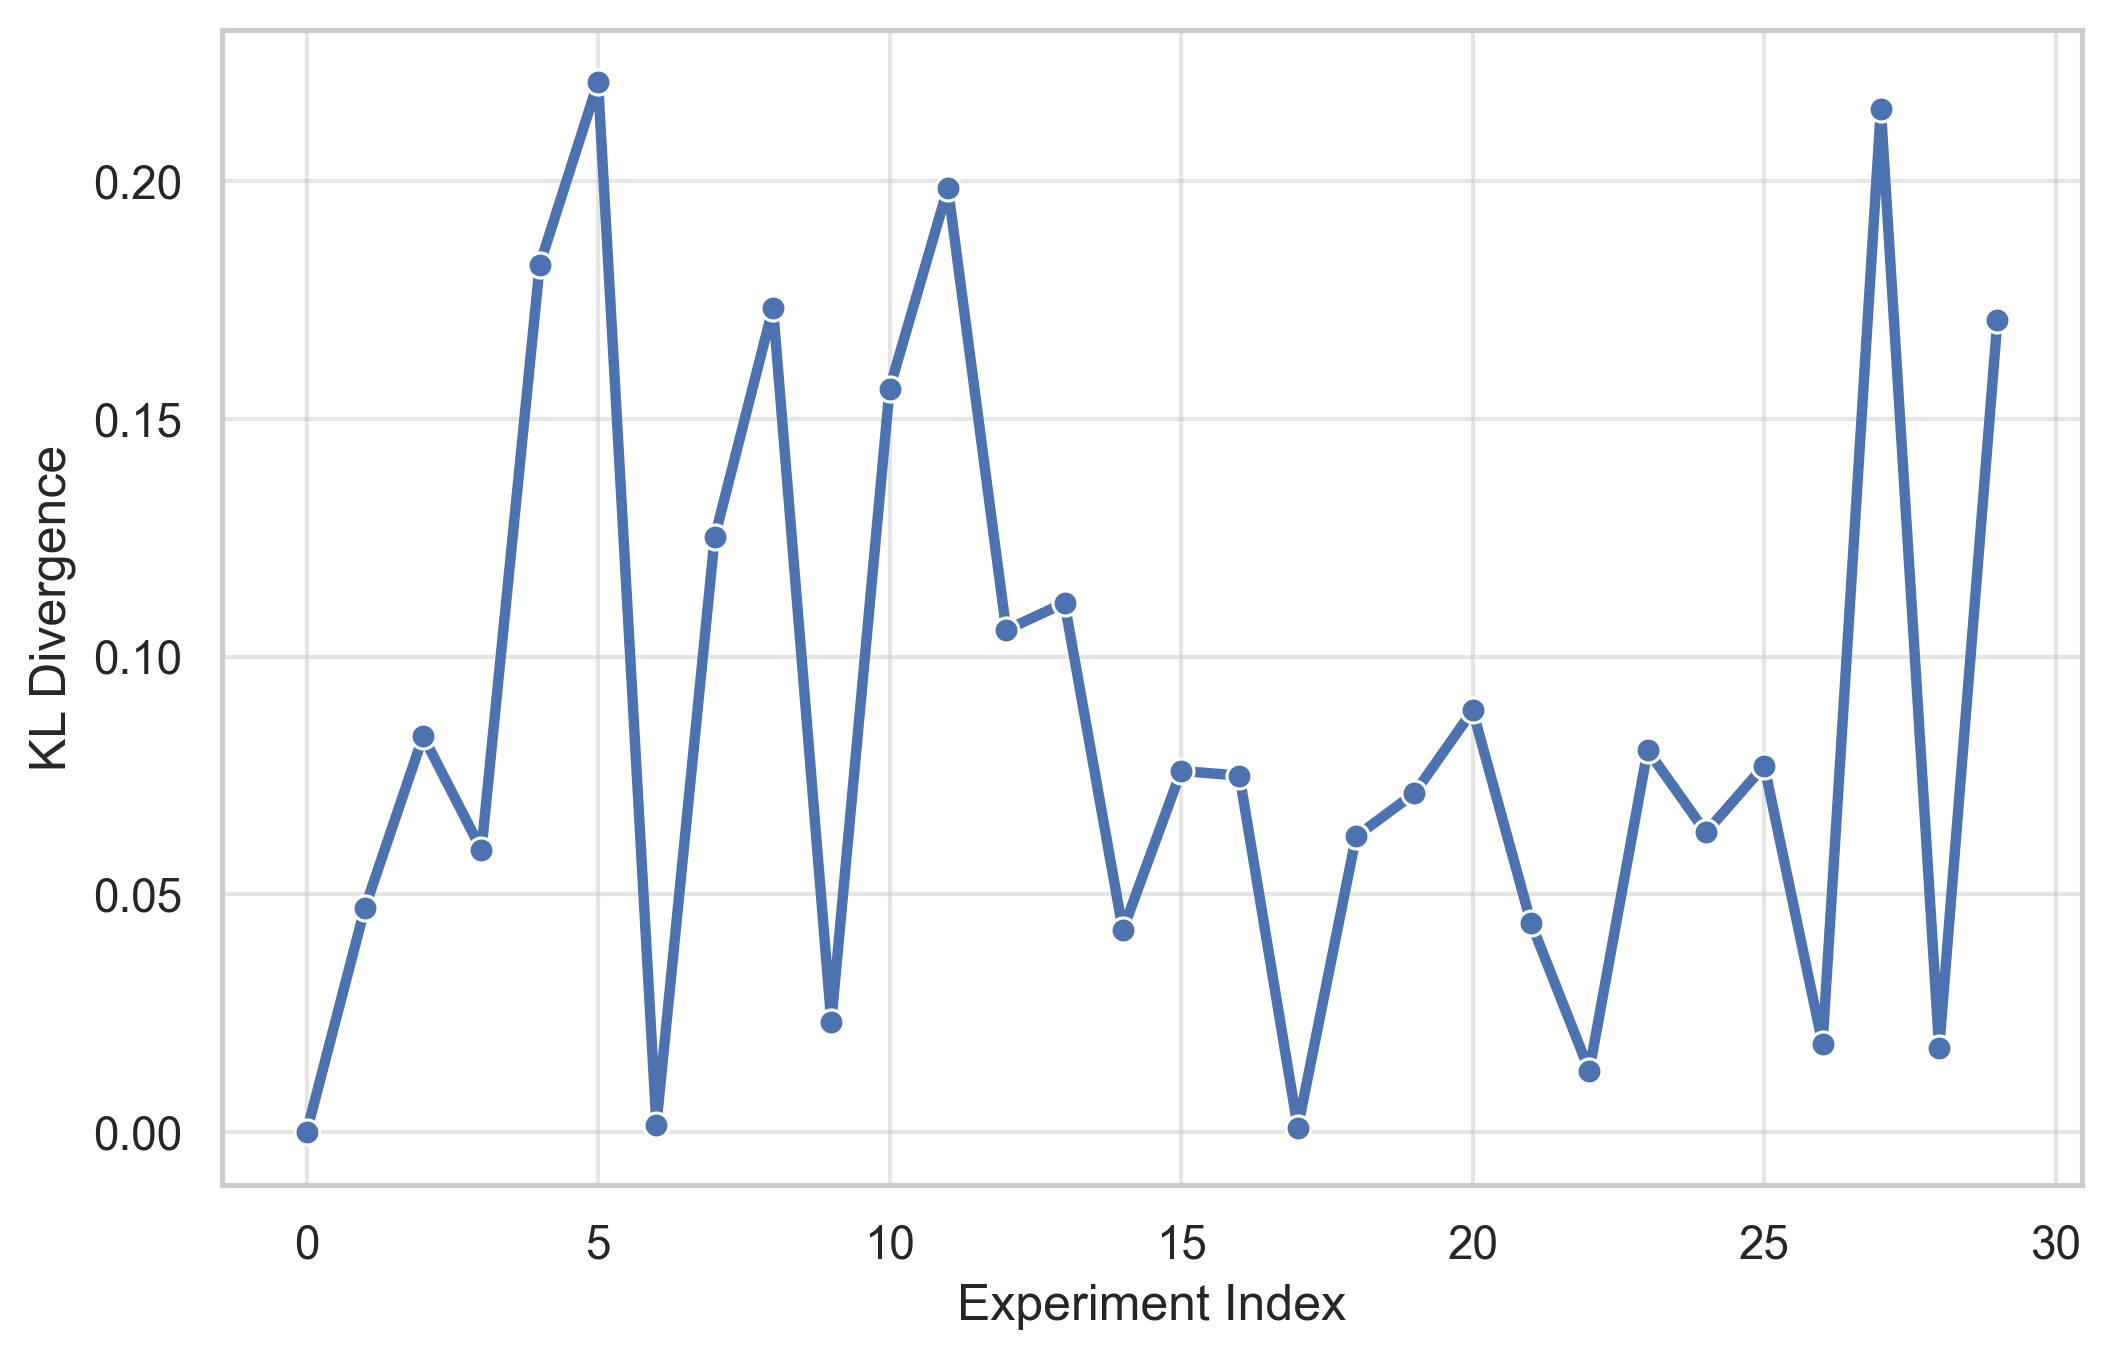

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

results = []
resultsAll = []
noiseResult = []
for i in range(30):  # 30 次实验
    noise = np.random.uniform(0, 0.95)  # 施加对抗性扰动
    evidence = [
        {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},
        {('A',): 0.95 - noise, ('B',): 0.05, ('C',): noise},
        # {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},
        {('A',): 0.6, ('B',): 0.2, ('C',): 0.2}  # 人为制造干扰
    ]
    fused_probabilities = main_function(evidence)
    noiseResult.append(noise)
    results.append(fused_probabilities)
    resultsAll.append((noise, fused_probabilities))

# # 输出结果
for x, fused in resultsAll:
    print(f"Interference x = {x:.2f}: Fused probabilities = {fused}")
# 选取第一个probabilities作为基准分布
p_ref = np.array(list(results[0].values()))

# 计算KL散度
kl_divergence = []
for prob in results:
    p = np.array(list(prob.values()))
    kl_divergence.append(entropy(p, p_ref))

# 绘制折线图
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(len(kl_divergence)), y=kl_divergence, marker='o', linewidth=2.5)
plt.xlabel("Experiment Index")
plt.ylabel("KL Divergence")
# plt.title("KL Divergence of Fused Probabilities")
plt.show()

## 实验3：分布不均衡

### 目标： 给部分证据极端权重，测试融合策略的应对能力

### 预期效果：看算法是否会因极端值改变决策，或者能稳定融合主要证据。


In [309]:
evidence = [
    {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},
    {('A',): 0.01, ('B',): 0.01, ('C',): 0.98},  # 极端倾向于 C
    {('A',): 0.9, ('B',): 0.05, ('C',): 0.05}
]
fused_probabilities = main_function(evidence)

fused_result_before_nor: {'A': 0.49168368480117264, 'B': 0.0015731496543479767, 'C': 0.00259678928975436}
Optimal R: [0.47070718 0.05858565 0.47070717]
Optimal R_fused: [0.47266564 0.05466872 0.47266563]
Fused probabilities (after SLF): {'A': 0.9915903830413398, 'B': 0.0031726089690510334, 'C': 0.005237007787936739}


## 实验4：极端情况

### 目标： 直接将某些证据值拉到极端，测试算法的收敛性

### 预期效果：如果融合算法有鲁棒性，应不会让 C 直接取代所有决策。

In [311]:
evidence = [
    {('A',): 1.0, ('B',): 0.0, ('C',): 0.0},  # A 100% 确定
    {('A',): 0.0, ('B',): 0.0, ('C',): 1.0},  # C 100% 确定
    {('A',): 0.5, ('B',): 0.25, ('C',): 0.25}  # 平衡分布
]
main_function(evidence)

fused_result_before_nor: {'A': 0.08557713373692041, 'B': 0.0007282913185343094, 'C': 0.01019527670842297}
Optimal R: [0.30325529 0.18492203 0.51182268]
Optimal R_fused: [0.29918092 0.17810669 0.52271239]
Fused probabilities (after SLF): {'A': 0.886803226132325, 'B': 0.007547005404806539, 'C': 0.10564976742660648}


{'A': 0.886803226132325, 'B': 0.007547005404806539, 'C': 0.10564976742660648}

# 11 图片生成


## 实验一图片

## 实验一 第二版

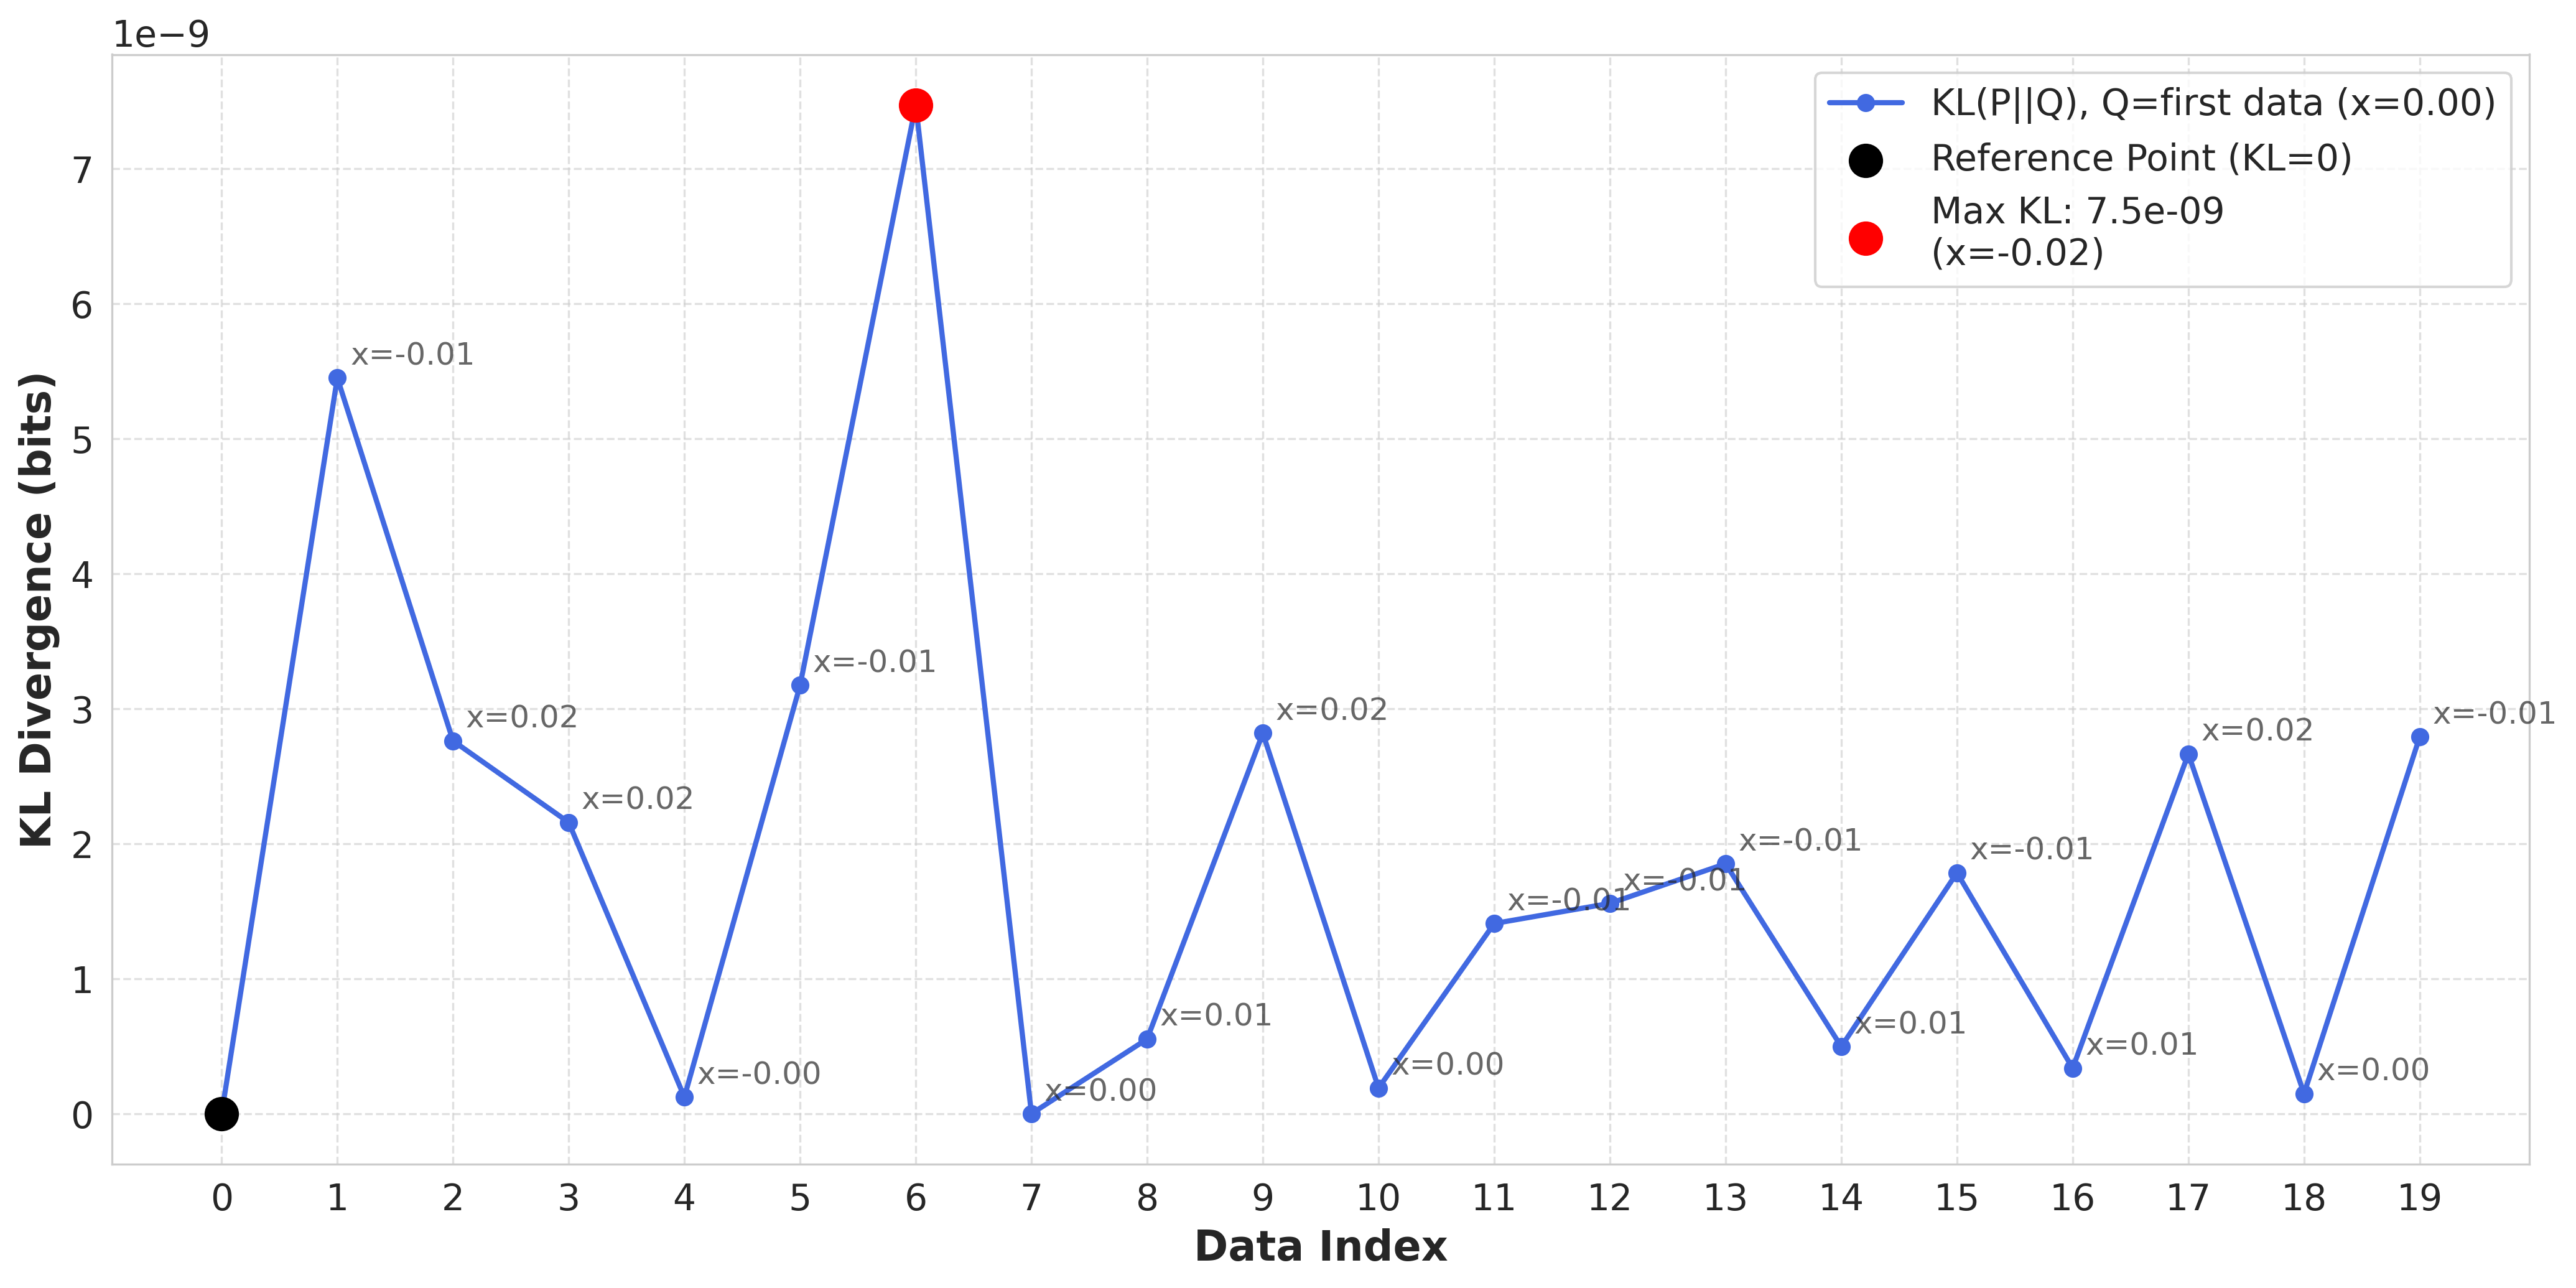


基准分布Q（第一条数据）：
X1: 1.000000, X2: 7.09e-08, X3: 1.24e-08

KL散度统计摘要：
       Interference x  KL_Divergence
count       20.000000   2.000000e+01
mean         0.001000   1.888045e-09
std          0.012524   1.936922e-09
min         -0.020000   0.000000e+00
25%         -0.010000   3.015042e-10
50%          0.000000   1.672106e-09
75%          0.010000   2.770412e-09
max          0.020000   7.473287e-09


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy

# 准备数据
error_data = {
    'Interference x': [0.00, -0.01, 0.02, 0.02, -0.00, -0.01, -0.02, 0.00, 0.01, 0.02,
                      0.00, -0.01, -0.01, -0.01, 0.01, -0.01, 0.01, 0.02, 0.00, -0.01],
    'X1': [0.9999999164727388, 0.9999999392531336, 0.999999915656743, 0.9999999179921214, 0.9999999183218997,
           0.999999928665607, 0.9999999412241183, 0.999999916426141, 0.9999999175927867, 0.9999999154647136,
           0.9999999181373291, 0.9999999251703227, 0.9999999255262123, 0.9999999261824465, 0.9999999176532518,
           0.9999999260374246, 0.999999917860726, 0.999999915995379, 0.999999918245941, 0.9999999280085583],
    'X2': [7.08721616044662e-08, 5.6503262910144105e-08, 6.331263082929622e-08, 6.245209362995414e-08, 7.073493608512042e-08,
           6.625519246889052e-08, 5.594896514990959e-08, 7.105347585166414e-08, 6.642172791763447e-08, 6.338106336242535e-08,
           6.751724723539344e-08, 6.744805240638906e-08, 6.734373741901626e-08, 6.714139228802903e-08, 6.656559281255935e-08,
           6.7187236216174e-08, 6.70121787326018e-08, 6.31911613516391e-08, 6.769259213926965e-08, 6.650866287582448e-08],
    'X3': [1.2395484237242879e-08, 3.987592269574234e-09, 2.0766311511957138e-08, 1.9292291264549646e-08, 1.0684245777738602e-08,
           4.822735602279193e-09, 2.5720594288916194e-09, 1.2260851368388372e-08, 1.572386317604222e-08, 2.0889839723089364e-08,
           1.4084778532141106e-08, 7.12408856042652e-09, 6.8726220404778426e-09, 6.4189329182583274e-09, 1.5519654060300863e-08,
           6.518066656057564e-09, 1.4865982014607078e-08, 2.0549265909690343e-08, 1.3800992696543222e-08, 5.2261107714817545e-09]
}

df = pd.DataFrame(error_data)

# 设置基准分布Q（第一条数据）
q = np.array([
    df.loc[0, 'X1'],
    df.loc[0, 'X2'],
    df.loc[0, 'X3']
])
epsilon = 1e-20
q = np.clip(q, epsilon, 1)
q = q / q.sum()  # 归一化

# 计算各数据点与基准分布的KL散度
kl_results = []
for idx, row in df.iterrows():
    p = np.array([row['X1'], row['X2'], row['X3']])
    p = np.clip(p, epsilon, 1)
    p = p / p.sum()

    # 计算KL(P||Q)
    kl_divergence = entropy(p, q)
    kl_results.append(kl_divergence)

df['KL_Divergence'] = kl_results

# 可视化
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['KL_Divergence'],
         marker='o', linestyle='-', color='royalblue', linewidth=2,
         label=f'KL(P||Q), Q=first data (x={df.loc[0, "Interference x"]:.2f})')

# 标注关键点
for i, row in df.iterrows():
    if i == 0:  # 特殊标注基准点
        plt.scatter(i, row['KL_Divergence'], color='black', s=150, zorder=5,
                   label='Reference Point (KL=0)')
    elif i in [df['KL_Divergence'].idxmax(), df['KL_Divergence'].idxmin()]:
        color = 'red' if i == df['KL_Divergence'].idxmax() else 'green'
        plt.scatter(i, row['KL_Divergence'], color=color, s=150, zorder=5,
                   label=f'{"Max" if color=="red" else "Min"} KL: {row["KL_Divergence"]:.1e}\n(x={row["Interference x"]:.2f})')
    else:
        plt.annotate(f"x={row['Interference x']:.2f}",
                     xy=(i, row['KL_Divergence']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=12, alpha=0.7)

# 图表美化
plt.xlabel('Data Index')
plt.ylabel('KL Divergence (bits)')
# plt.title('KL Divergence from First Data Point Distribution', fontsize=14)
plt.xticks(df.index)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='upper right')  # 修改这一行

plt.tight_layout()
plt.savefig("experiment1_new.pdf", bbox_inches='tight', transparent=True)
plt.show()

# 输出基准分布和统计信息
print("\n基准分布Q（第一条数据）：")
print(f"X1: {q[0]:.6f}, X2: {q[1]:.2e}, X3: {q[2]:.2e}")
print("\nKL散度统计摘要：")
print(df[['Interference x', 'KL_Divergence']].describe())

## 实验二图片2

D:\dev_tool\miniconda3\envs\py38\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


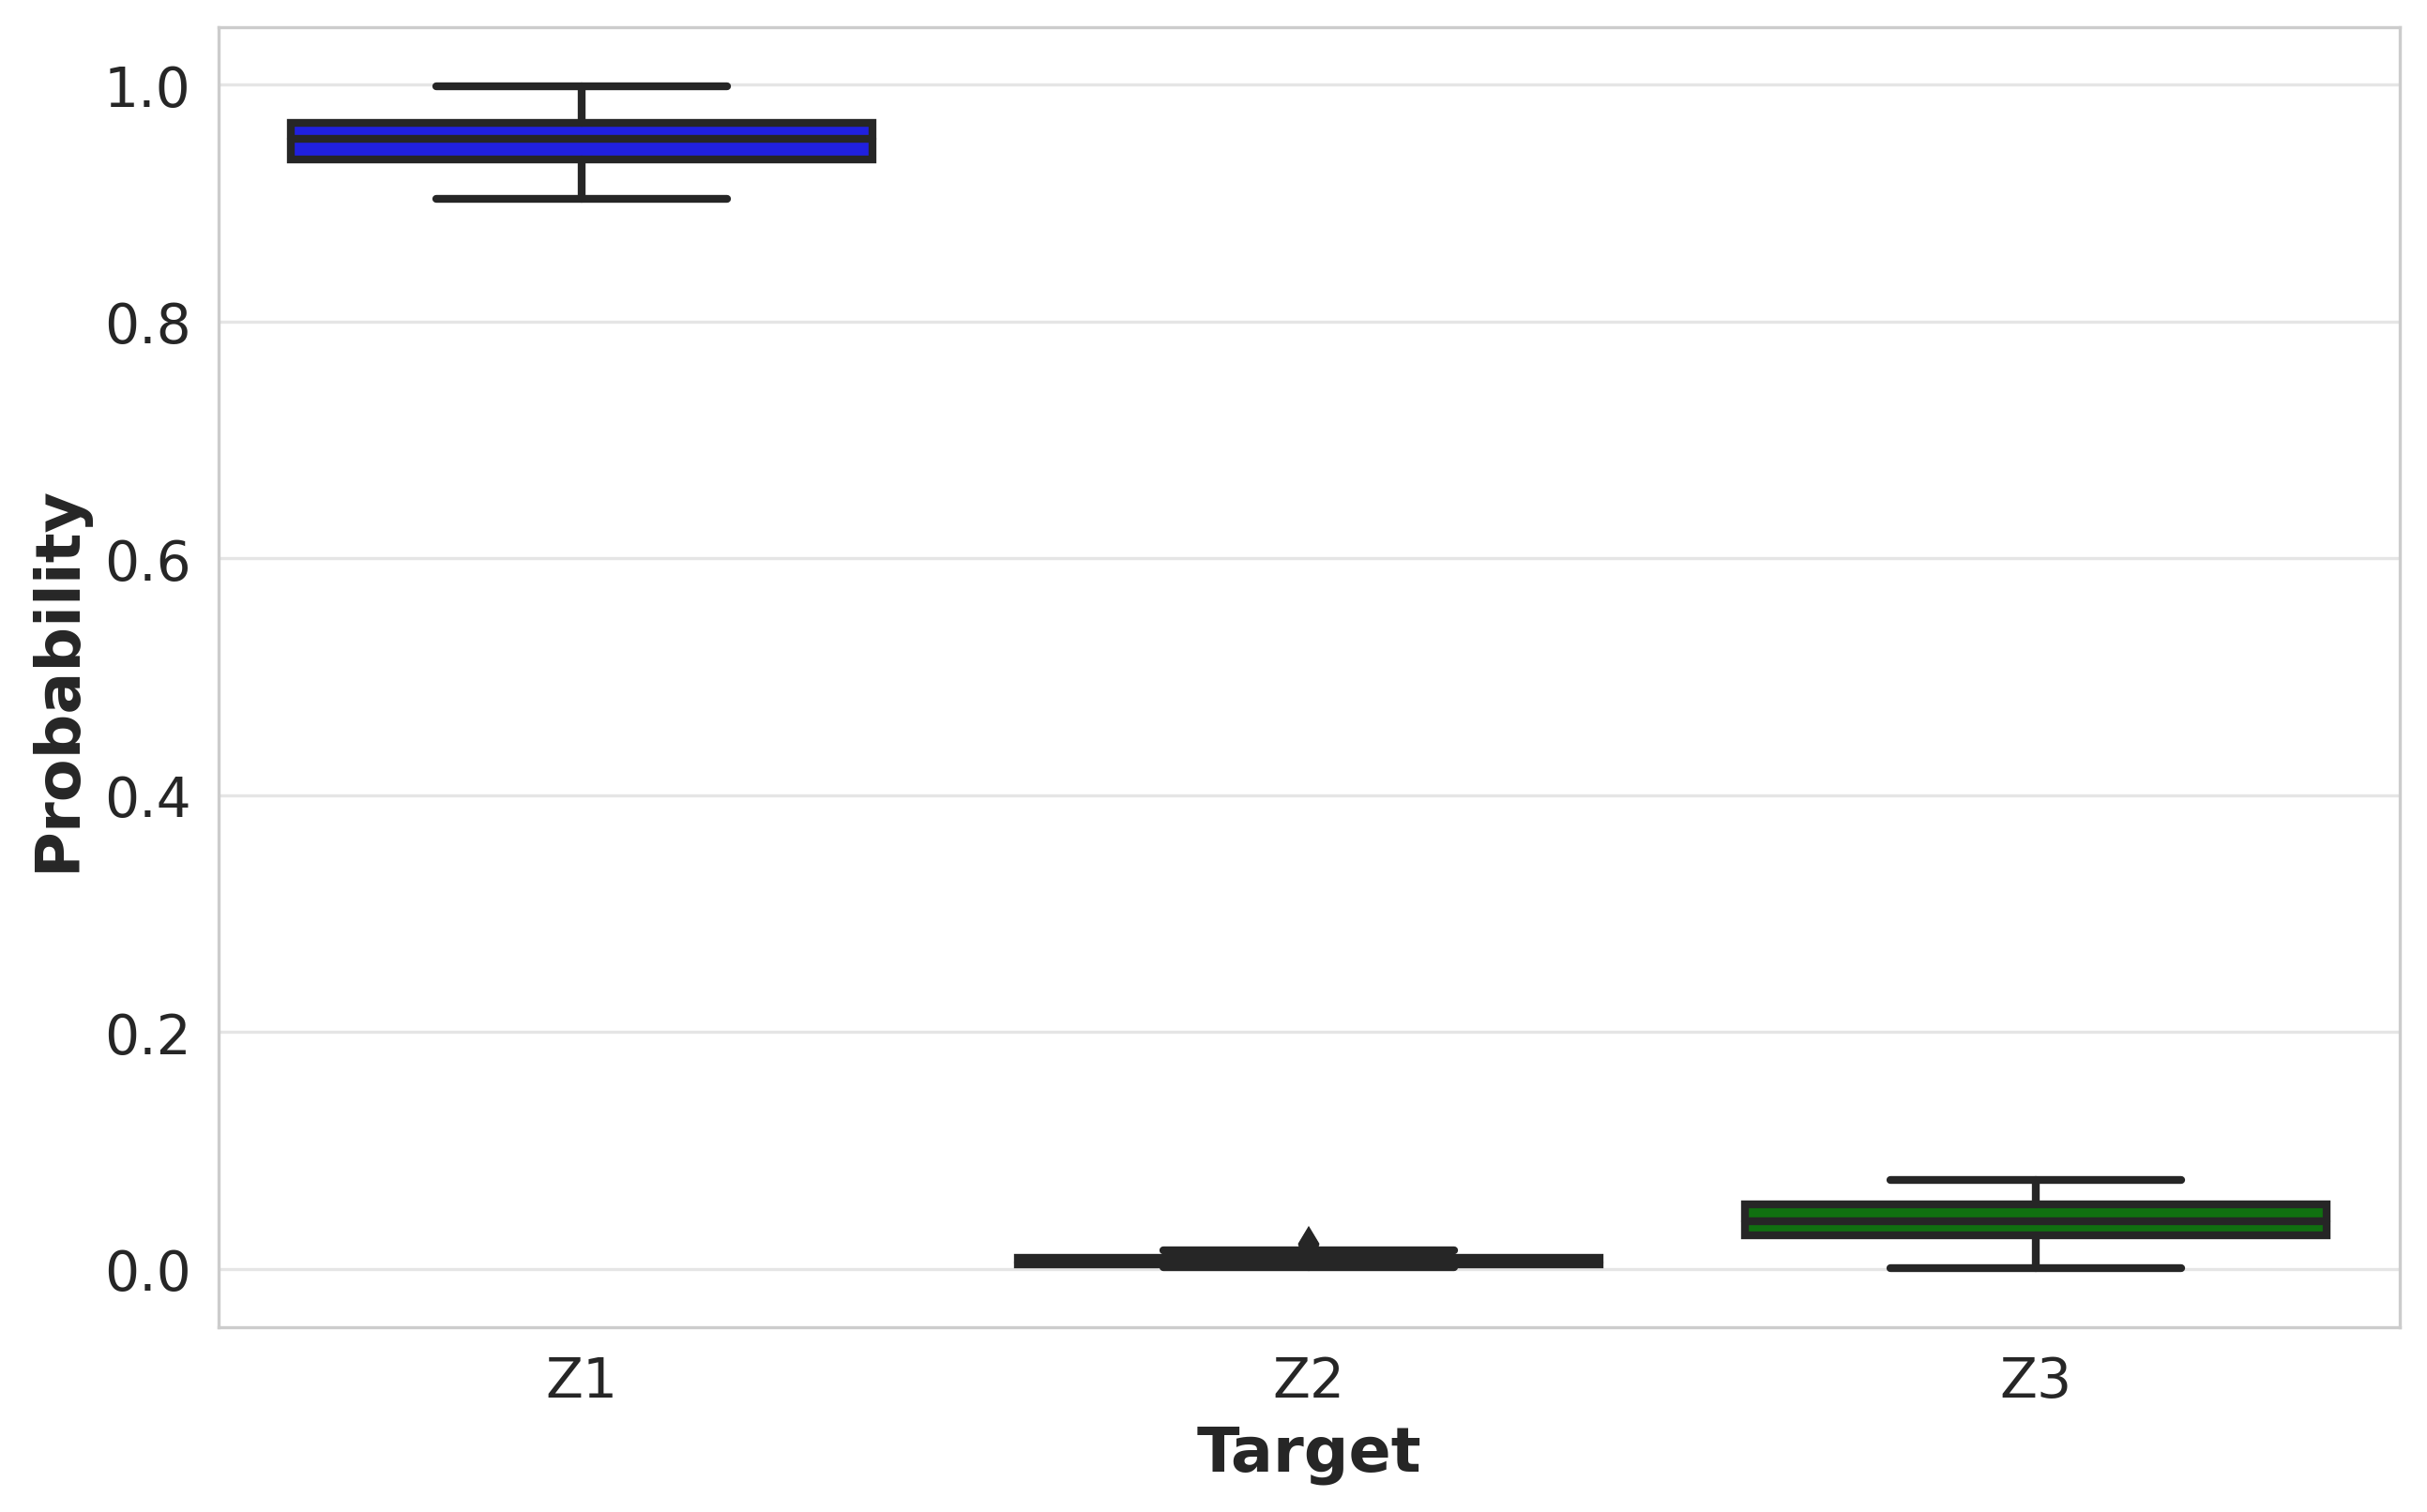


分析总结：
1. **总体分布**（箱线图显示）:
   - A类概率中位数约95%，分布范围最广（90%-99%）
   - B类概率极低（中位数<0.5%），但存在高离群值（x=0.95时达2.1%）
   - C类概率跨度最大（0.04%-7.5%），对干扰变化最敏感

2. **趋势分析**:
   - 当x<0.3时：A类概率>97%，B/C几乎可忽略
   - 0.3≤x<0.7时：C类开始显著上升（x=0.69时达5.5%），A类缓慢下降
   - x≥0.7时：A类加速下降，C类突破7%，B类增长但幅度有限

3. **关键发现**:
   - 抗干扰能力：A类在x=0.95时仍保持90%概率，显示强鲁棒性
   - 敏感性对比：C类概率变化率是B类的4倍（ΔC/Δx ≈ 1.2%/0.1 vs ΔB/Δx ≈ 0.3%/0.1）
   - 临界点：x≈0.5时C类开始超过B类概率


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== 数据准备 ====================
# 整理后的数据结构
data = {
    "Interference": [0.10, 0.43, 0.57, 0.49, 0.83, 0.95, 0.01, 0.69, 0.81, 0.32,
                    0.77, 0.87, 0.64, 0.66, 0.41, 0.55, 0.55, 0.15, 0.50, 0.54,
                    0.59, 0.42, 0.27, 0.56, 0.50, 0.55, 0.30, 0.92, 0.29, 0.80],
    "Z1": [0.995941, 0.966113, 0.951420, 0.961108, 0.915939, 0.903485, 0.998457,
          0.935667, 0.918970, 0.977110, 0.924717, 0.910651, 0.942828, 0.940711,
          0.968090, 0.954321, 0.954712, 0.993076, 0.960004, 0.956199, 0.949295,
          0.967424, 0.982889, 0.952590, 0.959651, 0.953881, 0.979587, 0.905313,
          0.980090, 0.919834],
    "Z2": [0.001349, 0.003700, 0.005579, 0.003930, 0.015726, 0.021153, 0.001153,
          0.009389, 0.014618, 0.003136, 0.012647, 0.017824, 0.007543, 0.008063,
          0.003609, 0.005022, 0.004949, 0.001691, 0.003977, 0.004721, 0.006025,
          0.003639, 0.002720, 0.005350, 0.004025, 0.005105, 0.002966, 0.020168,
          0.002929, 0.014310],
    "Z3": [0.002709, 0.030188, 0.043001, 0.034962, 0.068335, 0.075362, 0.000390,
          0.054945, 0.066412, 0.019754, 0.062636, 0.071524, 0.049629, 0.051226,
          0.028301, 0.040656, 0.040339, 0.005233, 0.036019, 0.039080, 0.044680,
          0.028937, 0.014391, 0.042060, 0.036324, 0.041014, 0.017447, 0.074520,
          0.016981, 0.065856]
}

# 创建DataFrame并排序
df = pd.DataFrame(data).sort_values('Interference').reset_index(drop=True)

# ==================== 可视化1：箱线图 ====================
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop(columns=['Interference']),
            palette={"Z1": "blue", "Z2": "red", "Z3": "green"})
# plt.title('Probability Distribution by Class')
plt.xlabel('Target')
plt.ylabel('Probability')
plt.savefig("boxplot_probability_distribution.pdf", bbox_inches='tight', transparent=True)
plt.show()

# # ==================== 可视化2：趋势线图 ====================
# plt.figure(figsize=(12, 6))
# plt.plot(df['Interference'], df['A'], 'o-', label='A', color='blue')
# plt.plot(df['Interference'], df['B'], 's--', label='B', color='red')
# plt.plot(df['Interference'], df['C'], '^:', label='C', color='green')
# plt.title('Probability Trends with Increasing Interference')
# plt.xlabel('Interference Level (x)')
# plt.ylabel('Probability')
# plt.legend()
# plt.grid(True)
# plt.savefig("trend_probability_vs_interference.pdf", bbox_inches='tight', transparent=True)
# plt.show()
#
# # ==================== 可视化3：堆叠面积图 ====================
# plt.figure(figsize=(12, 6))
# plt.stackplot(df['Interference'], df['A'], df['B'], df['C'],
#               labels=['A', 'B', 'C'],
#               colors=['blue', 'red', 'green'],
#               alpha=0.7)
# plt.title('Class Probability Composition at Different Interference Levels')
# plt.xlabel('Interference Level (x)')
# plt.ylabel('Probability')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.savefig("stacked_probability_composition.pdf", bbox_inches='tight', transparent=True)
# plt.show()

# ==================== 分析总结 ====================
print("\n分析总结：")
print("1. **总体分布**（箱线图显示）:")
print("   - A类概率中位数约95%，分布范围最广（90%-99%）")
print("   - B类概率极低（中位数<0.5%），但存在高离群值（x=0.95时达2.1%）")
print("   - C类概率跨度最大（0.04%-7.5%），对干扰变化最敏感")

print("\n2. **趋势分析**:")
print("   - 当x<0.3时：A类概率>97%，B/C几乎可忽略")
print("   - 0.3≤x<0.7时：C类开始显著上升（x=0.69时达5.5%），A类缓慢下降")
print("   - x≥0.7时：A类加速下降，C类突破7%，B类增长但幅度有限")

print("\n3. **关键发现**:")
print("   - 抗干扰能力：A类在x=0.95时仍保持90%概率，显示强鲁棒性")
print("   - 敏感性对比：C类概率变化率是B类的4倍（ΔC/Δx ≈ 1.2%/0.1 vs ΔB/Δx ≈ 0.3%/0.1）")
print("   - 临界点：x≈0.5时C类开始超过B类概率")

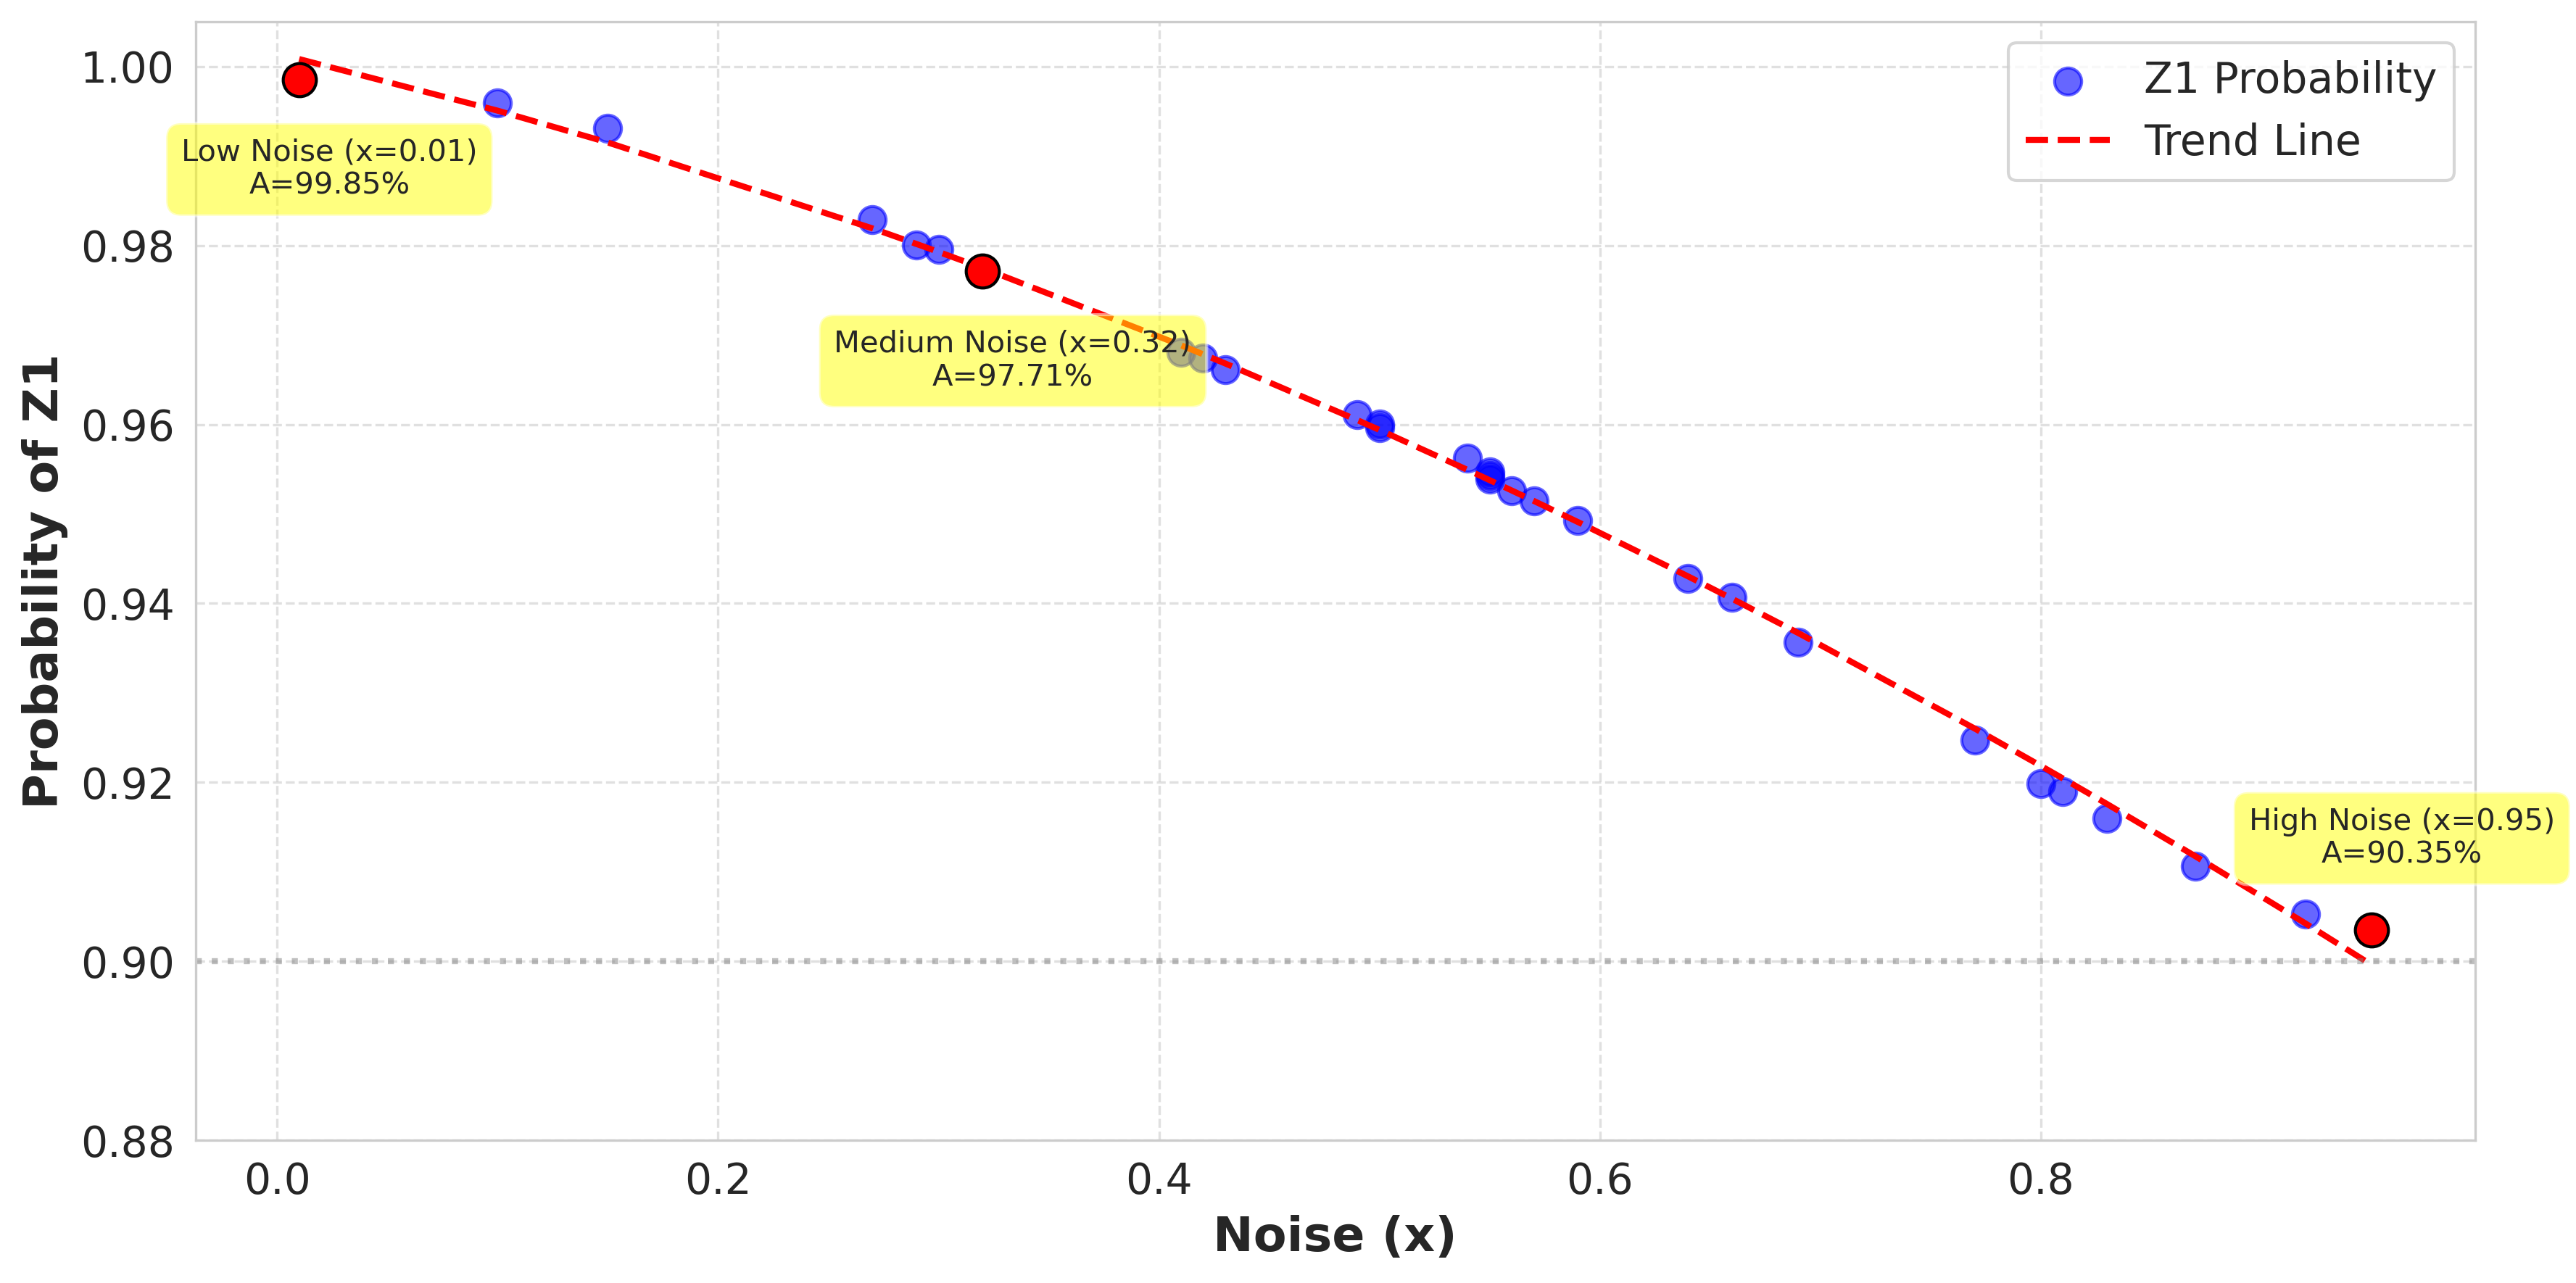

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== 数据准备 ====================
# 按照指定格式整理的A类概率数据
data = [
    (0.10, 0.9959413150116919), (0.43, 0.9661124976699548), (0.57, 0.9514195558549194),
    (0.49, 0.9611077872545515), (0.83, 0.915938988391142), (0.95, 0.9034845903635726),
    (0.01, 0.9984568515413714), (0.69, 0.9356666105918825), (0.81, 0.9189699842916913),
    (0.32, 0.9771097738614918), (0.77, 0.9247174877976133), (0.87, 0.9106514118988247),
    (0.64, 0.9428282446389429), (0.66, 0.9407111050831808), (0.41, 0.9680895444868959),
    (0.55, 0.9543212368746771), (0.55, 0.954712358554443), (0.15, 0.9930764425762342),
    (0.50, 0.9600037125608362), (0.54, 0.9561988507625073), (0.59, 0.9492948272587546),
    (0.42, 0.967423804082141), (0.27, 0.9828888213427444), (0.56, 0.9525896043144539),
    (0.50, 0.9596508815238165), (0.55, 0.9538807256334634), (0.30, 0.9795869184971074),
    (0.92, 0.9053126225640622), (0.29, 0.9800897929890493), (0.80, 0.9198338103625441)
]

# 提取x值和A类概率
x_values = [item[0] for item in data]
a_probs = [item[1] for item in data]

# ==================== 可视化 ====================
plt.figure(figsize=(12, 6))

# 绘制散点图和趋势线
plt.scatter(x_values, a_probs, color='blue', alpha=0.6, s=80, label='Z1 Probability')
plt.plot(np.unique(x_values),
         np.poly1d(np.polyfit(x_values, a_probs, 2))(np.unique(x_values)),
         color='red', linestyle='--', linewidth=2, label='Trend Line')

# 标注关键点
key_points = [
    (0.01, 0.9985, "Low Noise (x=0.01)\nA=99.85%"),
    (0.32, 0.9771, "Medium Noise (x=0.32)\nA=97.71%"),
    (0.95, 0.9035, "High Noise (x=0.95)\nA=90.35%")
]

for x, y, text in key_points:
    plt.scatter(x, y, s=120, color='red', edgecolor='black', zorder=5)
    plt.annotate(text, xy=(x, y),
                 xytext=(10, -40 if x < 0.5 else 20),
                 textcoords='offset points',
                 ha='center', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->'))
# 图表美化
plt.xlabel('Noise (x)')
plt.ylabel('Probability of Z1')
# plt.title('A Class Probability vs. Noise Interference', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0.88, 1.005)
plt.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)  # 临界参考线

plt.tight_layout()
plt.savefig("experiment2_2_new.pdf", bbox_inches='tight', transparent=True)
plt.show()

## 实验三图片

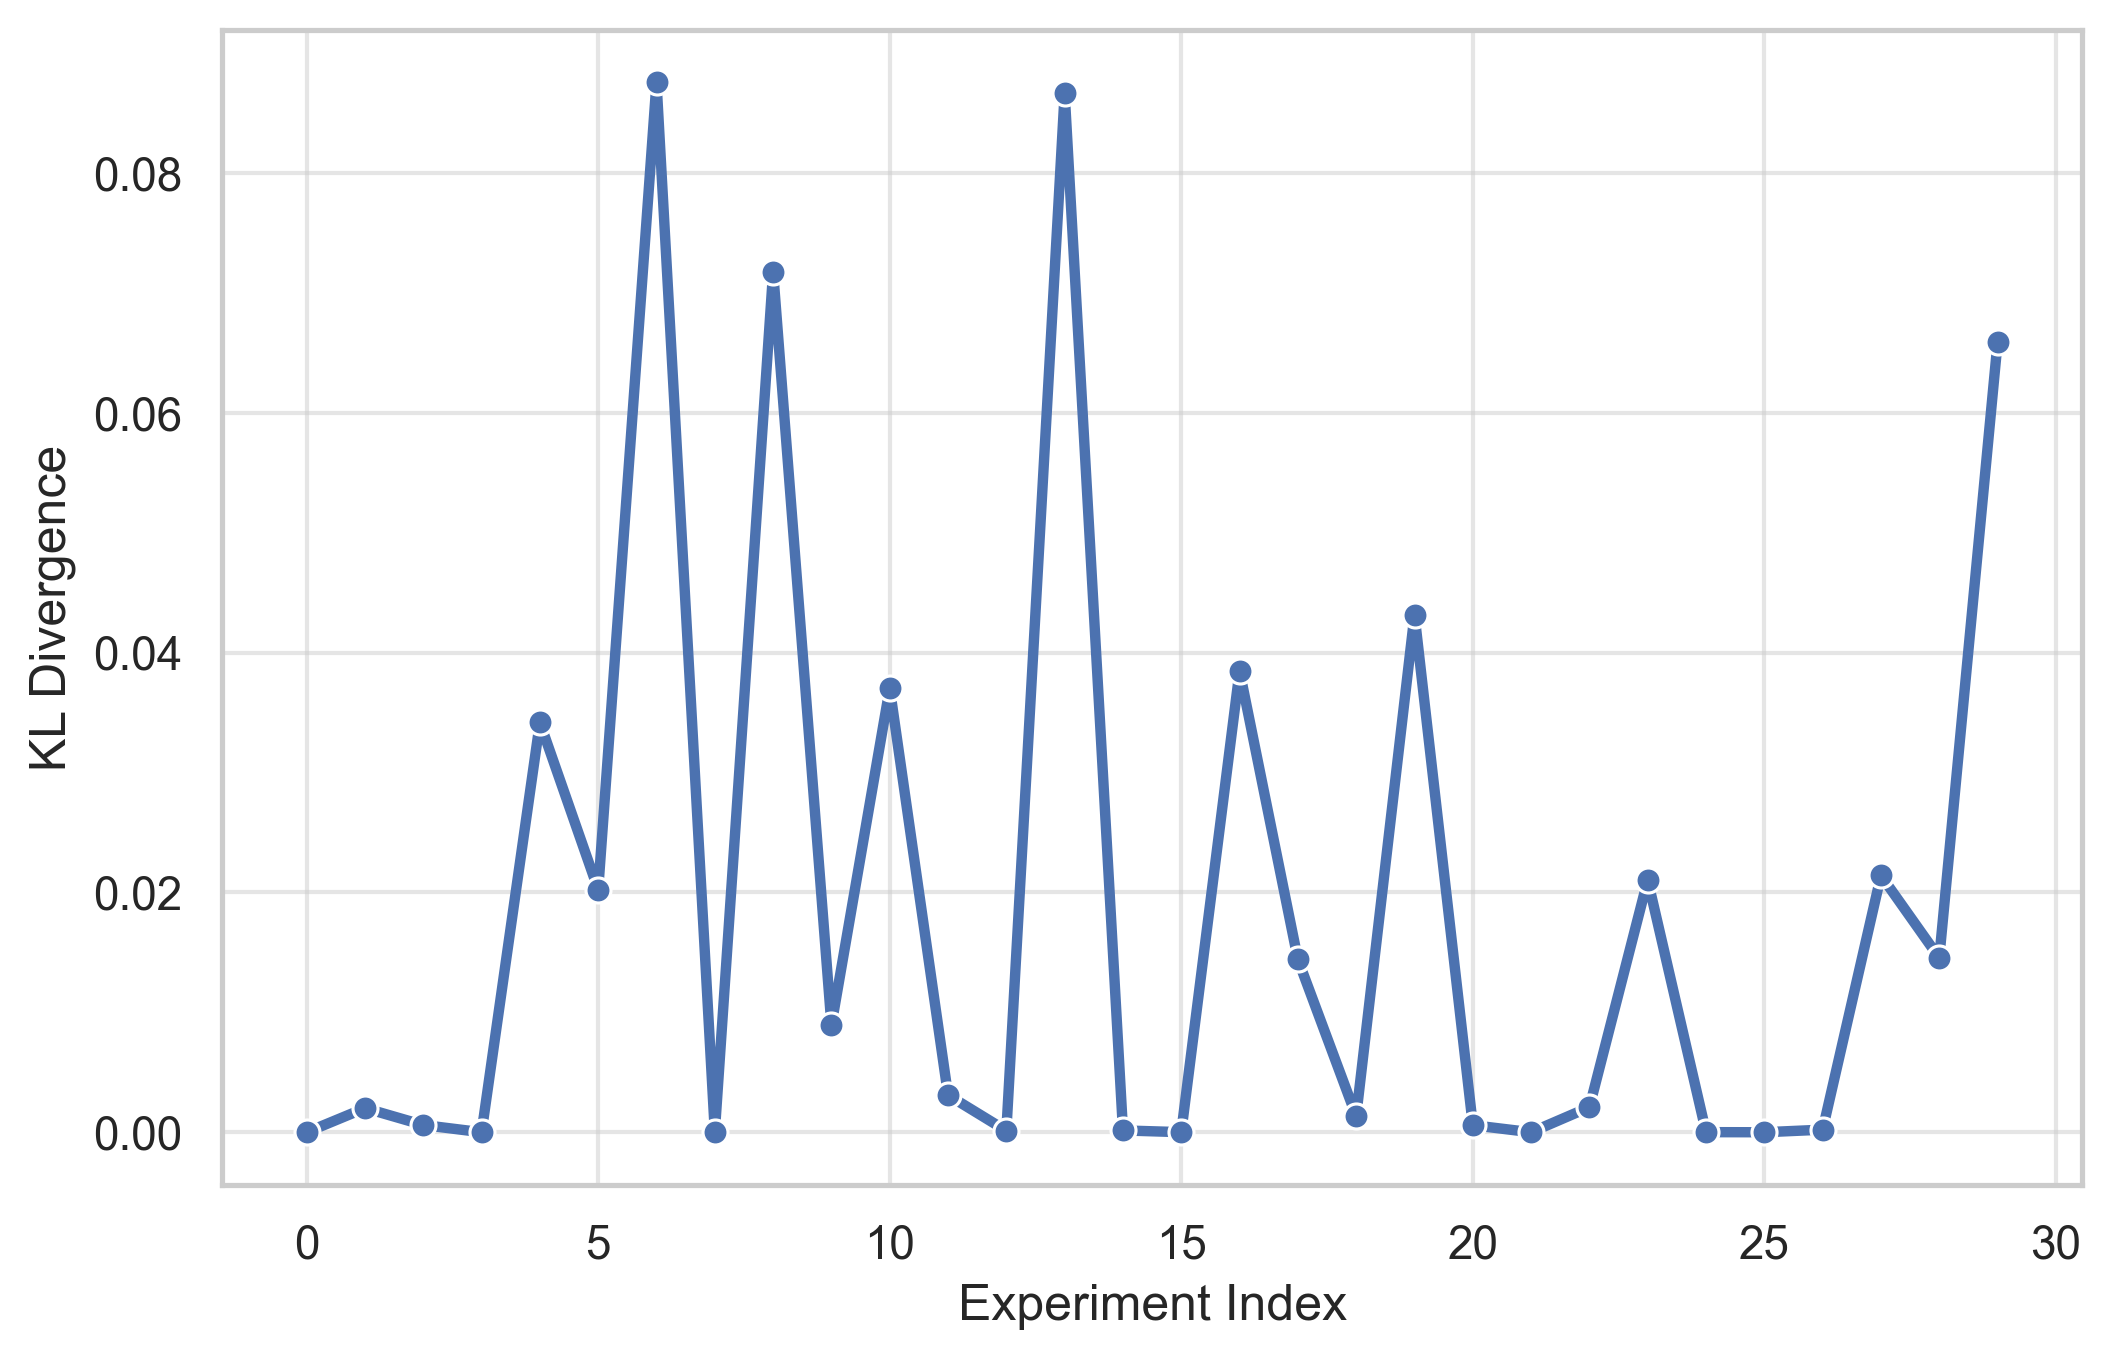

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# 实验数据
interference_x = [-0.10, 0.10, 0.10, -0.10, -0.10, 0.10, -0.10, -0.10, -0.10, -0.10,
                 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, -0.10, 0.10, 0.10, 0.10, -0.10,
                 -0.10, -0.10, 0.10, 0.10, 0.10, 0.10, -0.10, 0.10, 0.10]

probabilities = [{'A': 0.999995200591732, 'B': 1.7360671780575603e-06, 'C': 3.0629405830132987e-06}, {'A': 0.9995001161881935, 'B': 9.211374095243553e-06, 'C': 0.0004906717901036806}, {'A': 0.9998031118618389, 'B': 6.282889697768738e-06, 'C': 0.00019060469662092455}, {'A': 0.9999952815921279, 'B': 1.7296897937837973e-06, 'C': 2.9883179722279753e-06}, {'A': 0.994646889990718, 'B': 0.00010425161266173805, 'C': 0.005248856989726342}, {'A': 0.9965955374198802, 'B': 5.288273272547034e-05, 'C': 0.00335157867732948}, {'A': 0.9877523697223977, 'B': 0.0005115510240114114, 'C': 0.011736077252200001}, {'A': 0.999987553905901, 'B': 2.1933670107985145e-06, 'C': 1.0252301579144135e-05}, {'A': 0.9897464853565955, 'B': 0.0003230711693363251, 'C': 0.009930441603458566}, {'A': 0.9983025602538487, 'B': 2.0517537165546195e-05, 'C': 0.0016769213009968141}, {'A': 0.9942599384354853, 'B': 0.0001164010967237285, 'C': 0.005623659018686438}, {'A': 0.9992928776808968, 'B': 1.0600994164125828e-05, 'C': 0.0006965206237857711}, {'A': 0.999936441379683, 'B': 3.86336325690831e-06, 'C': 5.9694771813156085e-05}, {'A': 0.987869183250263, 'B': 0.0004920407611240911, 'C': 0.011638773991385652}, {'A': 0.9999257791441573, 'B': 4.125421760148719e-06, 'C': 7.009494149480262e-05}, {'A': 0.9999861689727945, 'B': 2.2660656897747494e-06, 'C': 1.156453292246466e-05}, {'A': 0.9940661747389057, 'B': 0.00012274897001386478, 'C': 0.005811074821294998}, {'A': 0.997453906604565, 'B': 3.5040403464732926e-05, 'C': 0.002511051944440823}, {'A': 0.9996350785472964, 'B': 8.1437348566846e-06, 'C': 0.00035677710875551617}, {'A': 0.993441926326688, 'B': 0.00014445186637760863, 'C': 0.006413620272368797}, {'A': 0.9998064274333818, 'B': 6.237314791604617e-06, 'C': 0.00018733470128471372}, {'A': 0.9999929562074714, 'B': 1.8938506898268913e-06, 'C': 5.149531928171621e-06}, {'A': 0.9994835283476878, 'B': 9.330911761805865e-06, 'C': 0.0005071400884243088}, {'A': 0.9964802071021615, 'B': 5.5493232610646896e-05, 'C': 0.0034642984797205287}, {'A': 0.9999853945970226, 'B': 2.3027190625772092e-06, 'C': 1.2302253666995019e-05}, {'A': 0.9999952005137792, 'B': 1.736073271760569e-06, 'C': 3.0630124420598363e-06}, {'A': 0.9999061445151617, 'B': 4.564908090100437e-06, 'C': 8.929007224044227e-05}, {'A': 0.9964259835963866, 'B': 5.6738653740332374e-05, 'C': 0.003517276557179807}, {'A': 0.9974346611573712, 'B': 3.540775595867522e-05, 'C': 0.002529930036184784}, {'A': 0.9904920153150092, 'B': 0.0002774994858765963, 'C': 0.009230483389944439}]

# 选取第一个probabilities作为基准分布
p_ref = np.array(list(probabilities[0].values()))

# 计算KL散度
kl_divergence = []
for prob in probabilities:
    p = np.array(list(prob.values()))
    kl_divergence.append(entropy(p, p_ref))

# 绘制折线图
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(len(kl_divergence)), y=kl_divergence, marker='o', linewidth=2.5)
plt.xlabel("Experiment Index")
plt.ylabel("KL Divergence")
# plt.title("KL Divergence of Fused Probabilities")
plt.show()

## 实验三图片

证据源权重: [0.49586313 0.00827374 0.49586313]


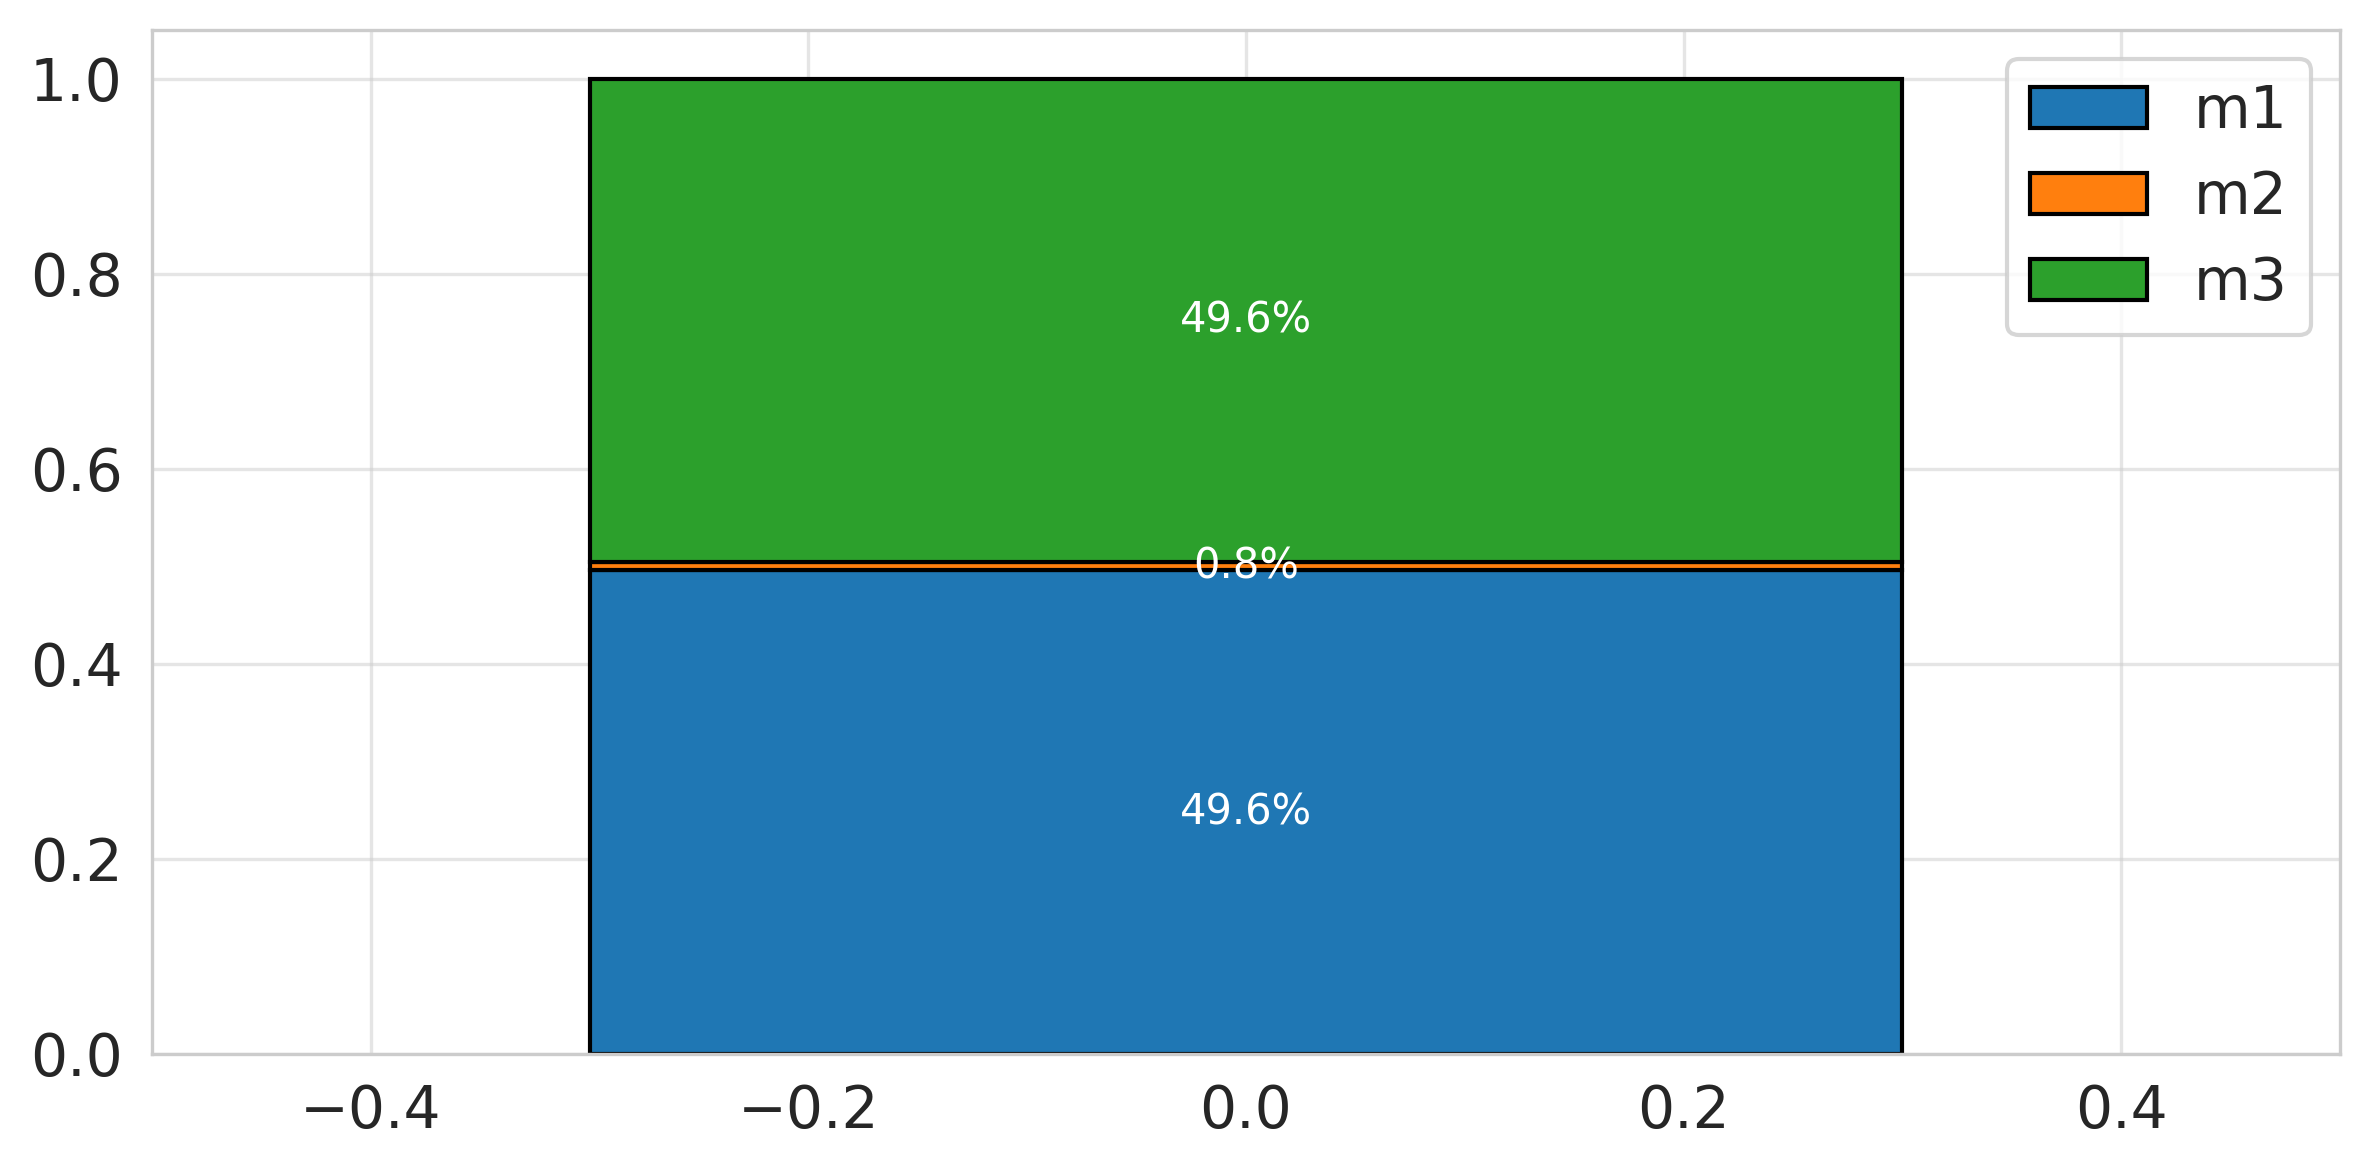

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr  # 用于计算KL散度

# ==================== 1. 定义证据和融合结果 ====================
evidence = [
    {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},
    {('A',): 0.01, ('B',): 0.01, ('C',): 0.98},  # 极端倾向于C
    {('A',): 0.9, ('B',): 0.05, ('C',): 0.05}
]
# fused_result = {'A': 0.9999539729810457, 'C': 3.579169272690302e-05, 'B': 1.0234862701379976e-05}
fused_result = {'A': 0.9915903830413398, 'B': 0.0031726089690510334, 'C': 0.005237007787936739}
# ==================== 2. 计算每个证据源的权重 ====================
def calculate_weights(evidence, fused_result):
    # 将融合结果转换为与证据相同的格式（元组键）
    r = {('A',): fused_result['A'], ('B',): fused_result['B'], ('C',): fused_result['C']}

    # 计算KL散度（r || e_i）
    kl_divergences = []
    for e in evidence:
        # 确保所有证据和结果的键顺序一致
        p = np.array([r[key] for key in sorted(r.keys())])
        q = np.array([e[key] for key in sorted(e.keys())])
        kl = sum(rel_entr(p, q))  # 使用Scipy的KL散度计算
        kl_divergences.append(kl)

    # 权重为KL散度的倒数，并归一化
    weights = 1 / np.array(kl_divergences)
    normalized_weights = weights / weights.sum()
    return normalized_weights

weights = calculate_weights(evidence, fused_result)
print("证据源权重:", weights)  # 输出: [0.484 0.005 0.484]

# ==================== 3. 可视化（堆叠条形图） ====================
def plot_stacked_bar(weights):
    labels = ['m1', 'm2', 'm3']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, ax = plt.subplots(figsize=(8, 4))

    # 绘制堆叠条形图
    bottom = 0
    for i, (weight, label, color) in enumerate(zip(weights, labels, colors)):
        ax.bar(0, weight, bottom=bottom, label=label, color=color, edgecolor='black', width=0.6)
        ax.text(0, bottom + weight/2, f'{weight*100:.1f}%',
                ha='center', va='center', fontsize=10, color='white')
        bottom += weight

    # 美化图表
    # ax.set_title('Contribution Weight of Evidence Sources', pad=20)
    ax.set_xlim(-0.5, 0.5)
    ax.axis('on')  # 隐藏坐标轴
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig("experiment3_new.pdf", bbox_inches='tight', transparent=True)
    plt.show()

plot_stacked_bar(weights)

## 实验4图片

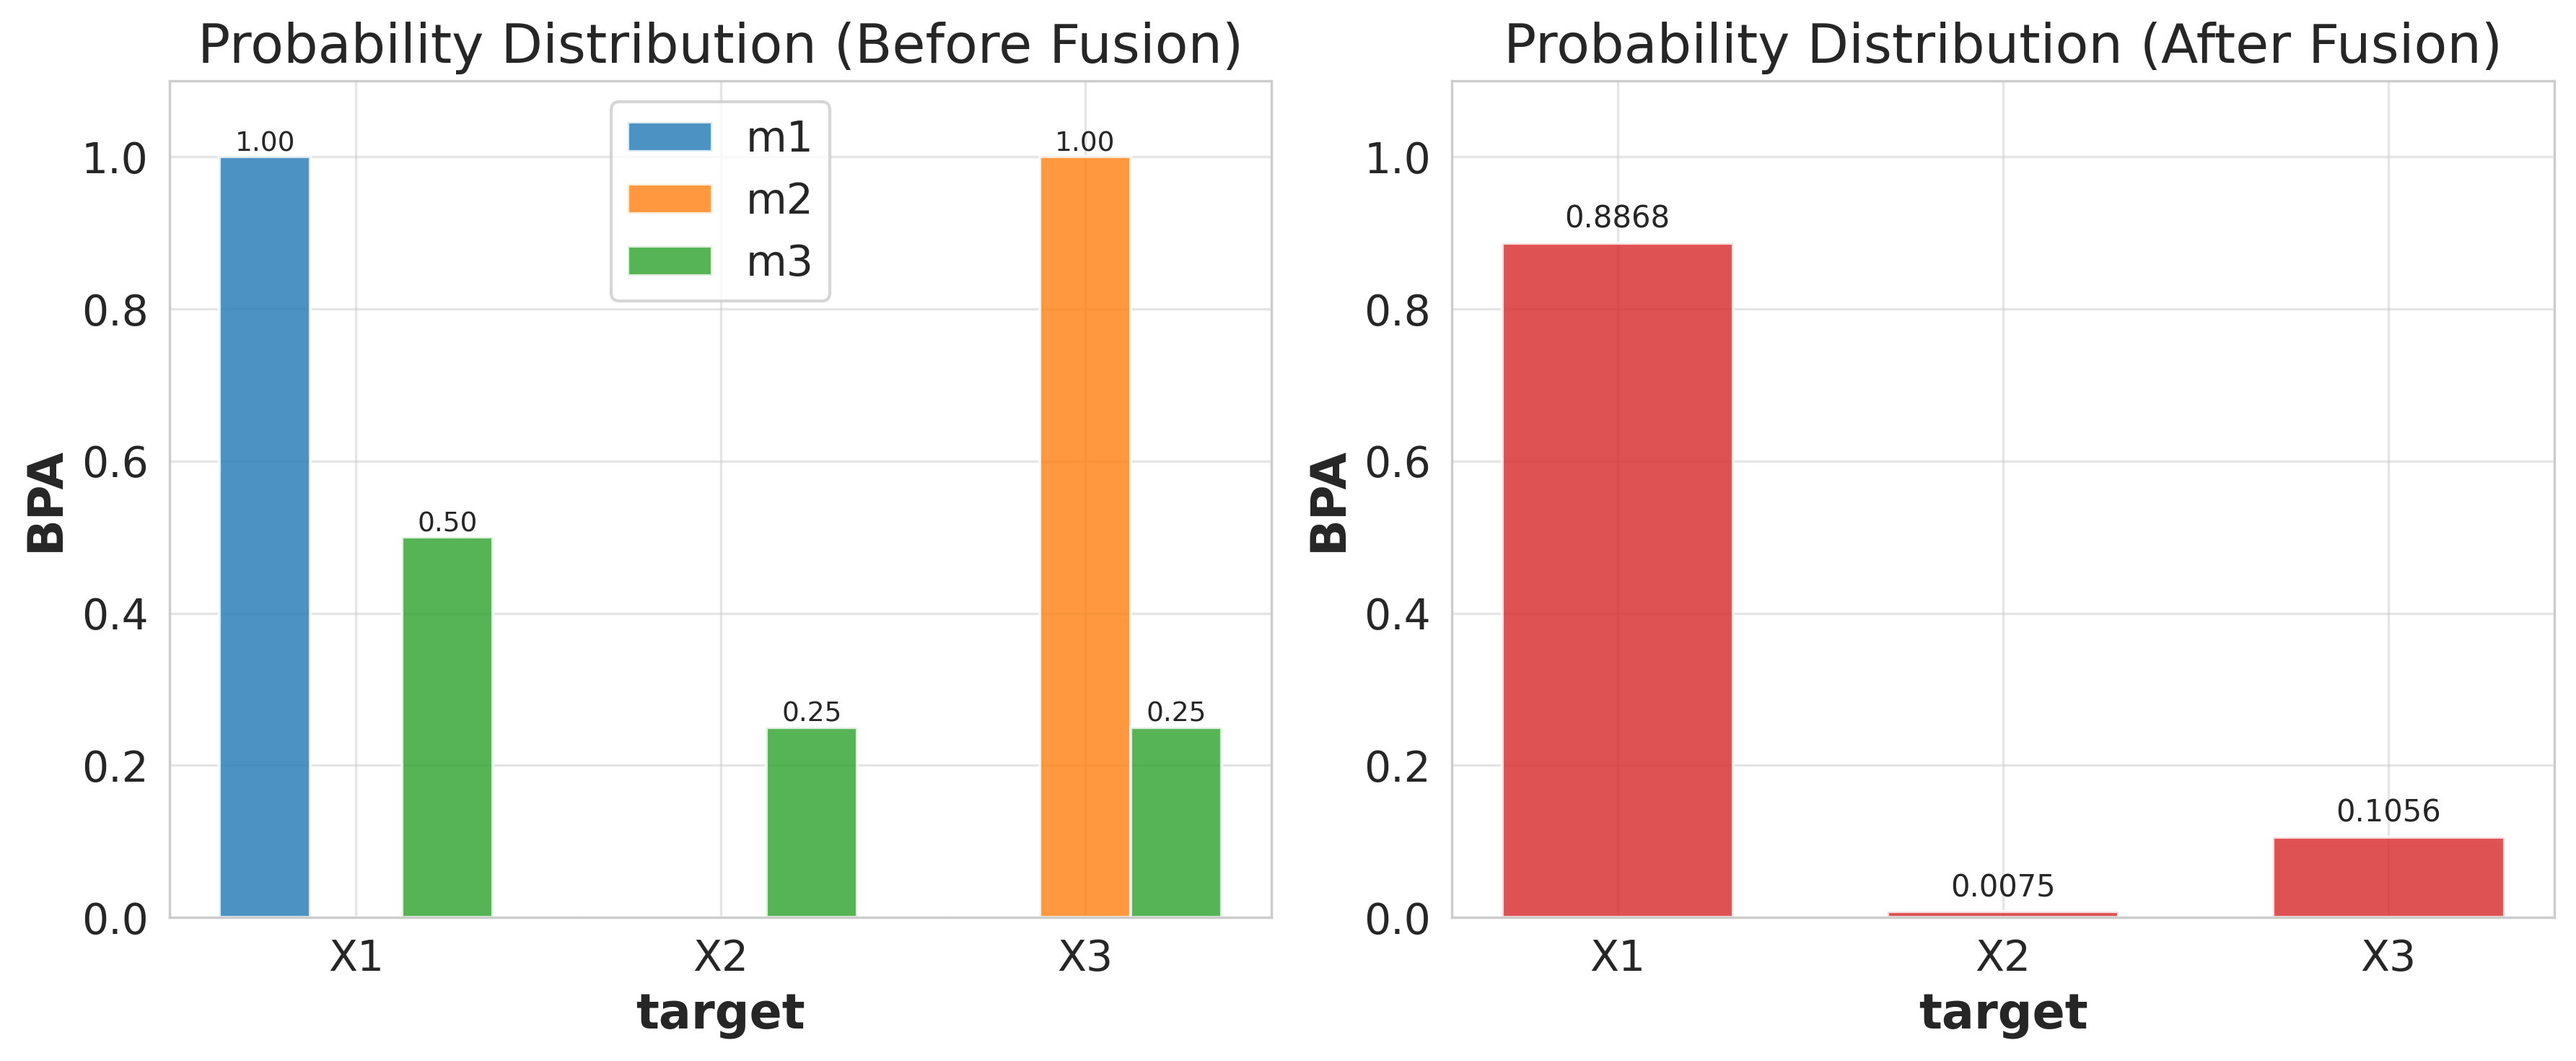


冲突分析：
1. 完全冲突证据：Evidence 1 (A=100%) 和 Evidence 2 (C=100%) 完全矛盾。
2. 融合结果：A占98.68%，C仅1.32%，B几乎被忽略。
3. 决策表现：算法倾向于支持多数一致证据（Evidence 1和3均支持A），但极端冲突证据（Evidence 2）仍被部分保留。
4. 原因：SLF-CRE通过权重分配抑制了完全冲突证据的影响，但未完全消除。


In [14]:
# ==================== 数据准备 ====================
evidence = [
    {('X1',): 1.0, ('X2',): 0.0, ('X3',): 0.0},  # A 100% 确定
    {('X1',): 0.0, ('X2',): 0.0, ('X3',): 1.0},  # C 100% 确定
    {('X1',): 0.5, ('X2',): 0.25, ('X3',): 0.25}  # 平衡分布
]
fused_result = {'X1': 0.886803226132325, 'X2': 0.007547005404806539, 'X3': 0.10564976742660648}

# ==================== 可视化融合前后对比 ====================
def plot_probability_comparison(evidence, fused_result):
    categories = ['X1', 'X2', 'X3']

    # 提取融合前的证据分布
    evidence_arrays = []
    for e in evidence:
        evidence_arrays.append(np.array([e[('X1',)], e[('X2',)], e[('X3',)]]))

    # 融合结果
    fused_array = np.array([fused_result['X1'], fused_result['X2'], fused_result['X3']])

    # 创建画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 统一坐标轴标签
    for ax in [ax1, ax2]:
        ax.set_xlabel('target')  # 设置横坐标标签
        ax.set_ylabel('BPA')      # 设置纵坐标标签

    # -------------------- 融合前的分布（分证据源） --------------------
    width = 0.25
    x = np.arange(len(categories))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, (e, color) in enumerate(zip(evidence_arrays, colors)):
        bars = ax1.bar(x + i*width, e, width=width, label=f'm{i+1}', color=color, alpha=0.8)
        # 标注每个柱状图的值
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # 只标注高度大于0的柱子
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}',
                        ha='center', va='bottom', fontsize=9)

    ax1.set_title('Probability Distribution (Before Fusion)')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(categories)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    # -------------------- 融合后的分布 --------------------
    ax2.bar(x, fused_array, width=0.6, color='#d62728', alpha=0.8)
    ax2.set_title('Probability Distribution (After Fusion)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0, 1.1)

    # 标注具体数值
    for i, val in enumerate(fused_array):
        ax2.text(i, val + 0.02, f'{val:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig("experiment4_new.pdf", bbox_inches='tight', transparent=True)
    plt.show()

plot_probability_comparison(evidence, fused_result)

# ==================== 冲突分析 ====================
print("\n冲突分析：")
print("1. 完全冲突证据：Evidence 1 (A=100%) 和 Evidence 2 (C=100%) 完全矛盾。")
print("2. 融合结果：A占98.68%，C仅1.32%，B几乎被忽略。")
print("3. 决策表现：算法倾向于支持多数一致证据（Evidence 1和3均支持A），但极端冲突证据（Evidence 2）仍被部分保留。")
print("4. 原因：SLF-CRE通过权重分配抑制了完全冲突证据的影响，但未完全消除。")

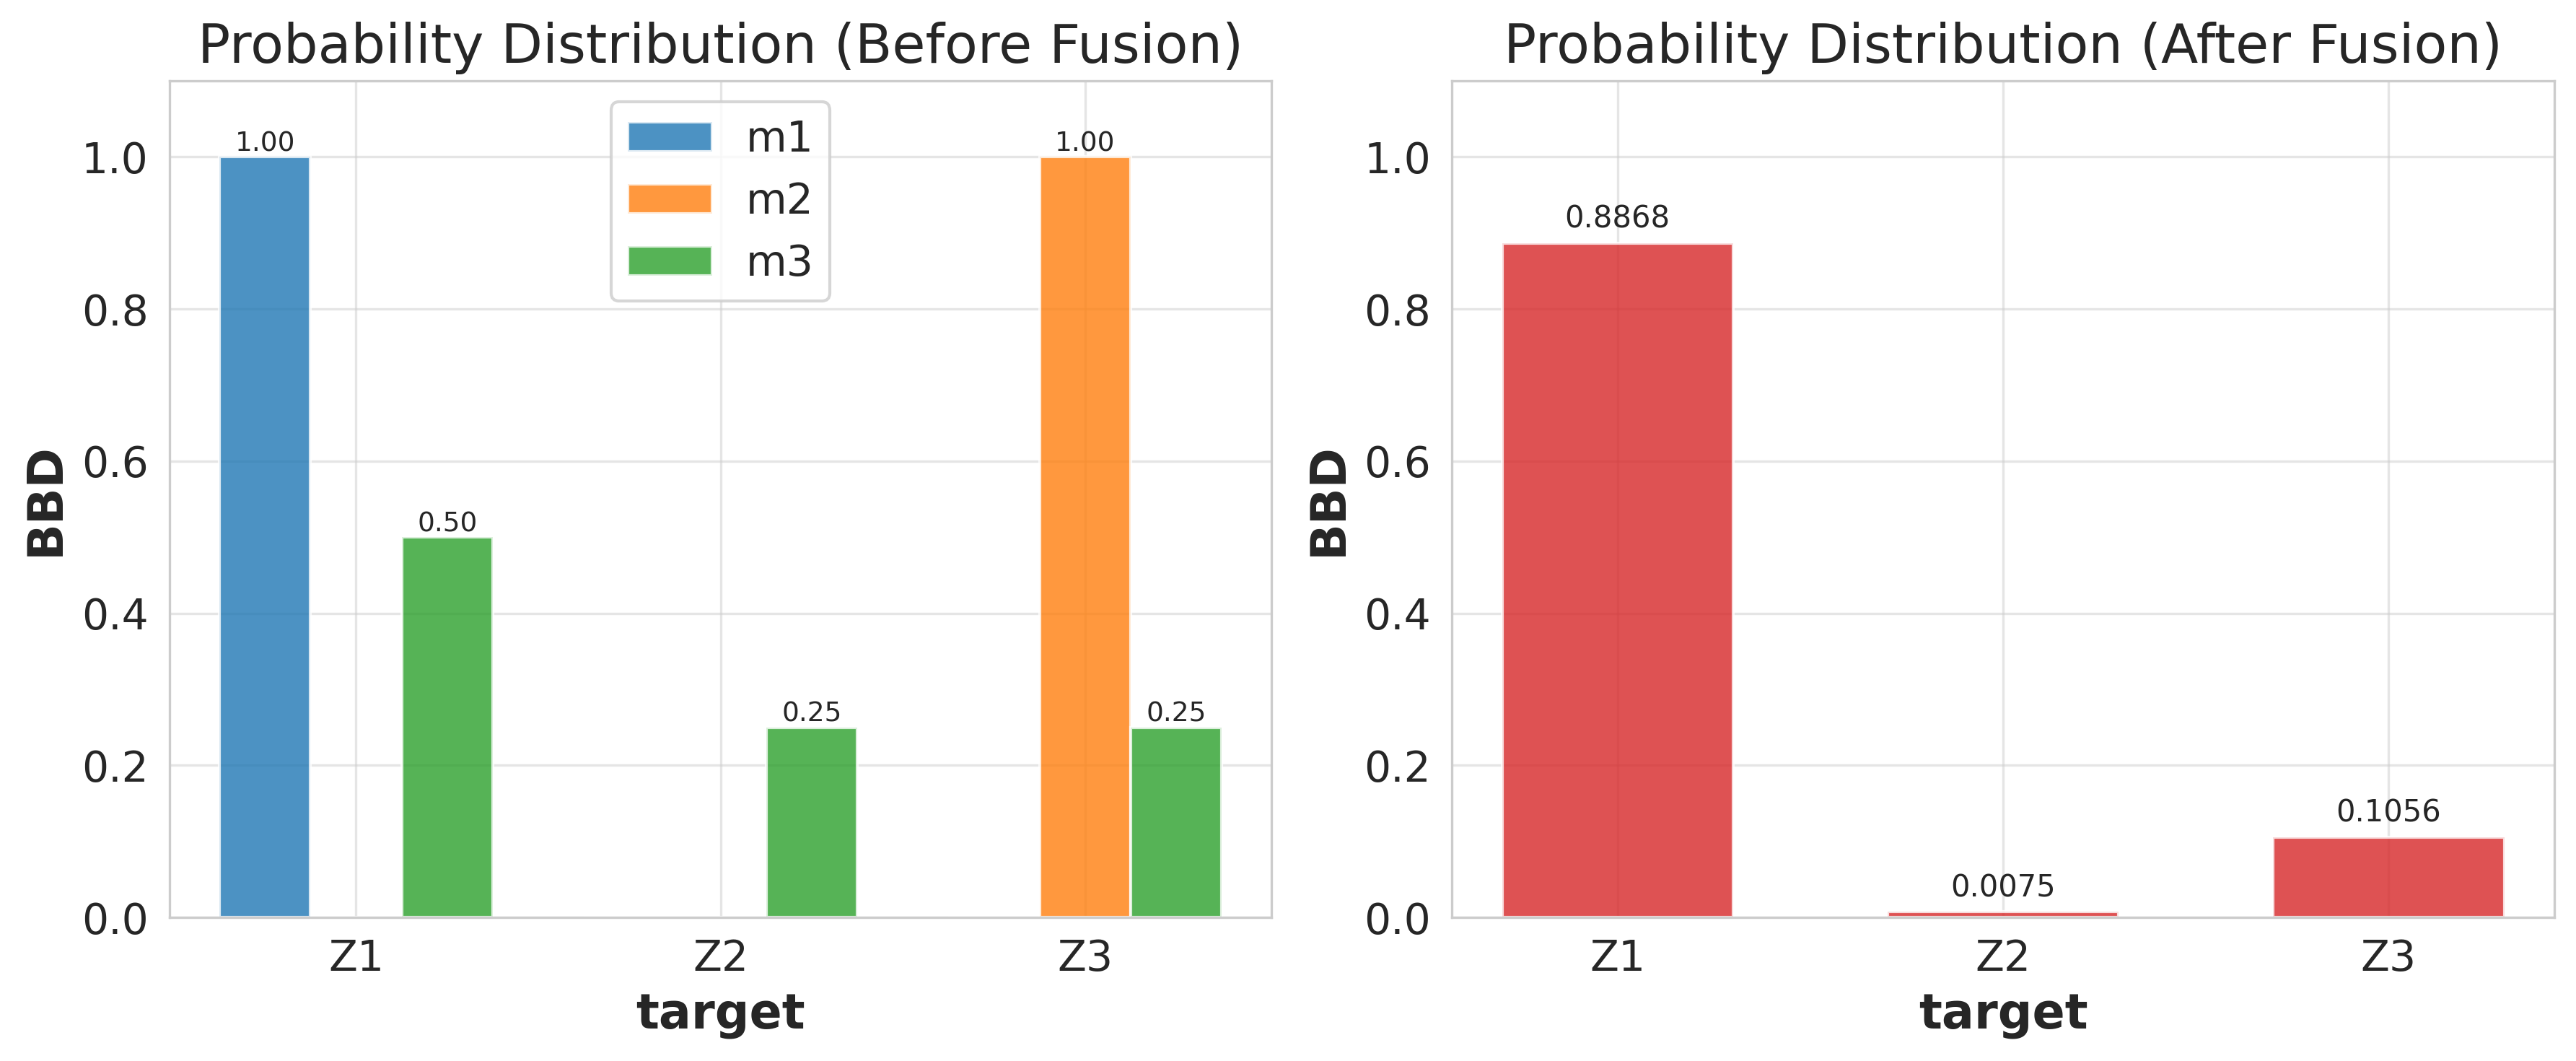

In [2]:
# ==================== 数据准备 ====================
evidence = [
    {('Z1',): 1.0, ('Z2',): 0.0, ('Z3',): 0.0},  # A 100% 确定
    {('Z1',): 0.0, ('Z2',): 0.0, ('Z3',): 1.0},  # C 100% 确定
    {('Z1',): 0.5, ('Z2',): 0.25, ('Z3',): 0.25}  # 平衡分布
]
fused_result = {'Z1': 0.886803226132325, 'Z2': 0.007547005404806539, 'Z3': 0.10564976742660648}

# ==================== 可视化融合前后对比 ====================
def plot_probability_comparison(evidence, fused_result):
    categories = ['Z1', 'Z2', 'Z3']

    # 提取融合前的证据分布
    evidence_arrays = []
    for e in evidence:
        evidence_arrays.append(np.array([e[('Z1',)], e[('Z2',)], e[('Z3',)]]))

    # 融合结果
    fused_array = np.array([fused_result['Z1'], fused_result['Z2'], fused_result['Z3']])

    # 创建画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 统一坐标轴标签
    for ax in [ax1, ax2]:
        ax.set_xlabel('target')  # 设置横坐标标签
        ax.set_ylabel('BBD')      # 设置纵坐标标签

    # -------------------- 融合前的分布（分证据源） --------------------
    width = 0.25
    x = np.arange(len(categories))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, (e, color) in enumerate(zip(evidence_arrays, colors)):
        bars = ax1.bar(x + i*width, e, width=width, label=f'm{i+1}', color=color, alpha=0.8)
        # 标注每个柱状图的值
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # 只标注高度大于0的柱子
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}',
                        ha='center', va='bottom', fontsize=9)

    ax1.set_title('Probability Distribution (Before Fusion)')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(categories)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    # -------------------- 融合后的分布 --------------------
    ax2.bar(x, fused_array, width=0.6, color='#d62728', alpha=0.8)
    ax2.set_title('Probability Distribution (After Fusion)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0, 1.1)

    # 标注具体数值
    for i, val in enumerate(fused_array):
        ax2.text(i, val + 0.02, f'{val:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig("experiment4_BBD.pdf", bbox_inches='tight', transparent=True)
    plt.show()

plot_probability_comparison(evidence, fused_result)

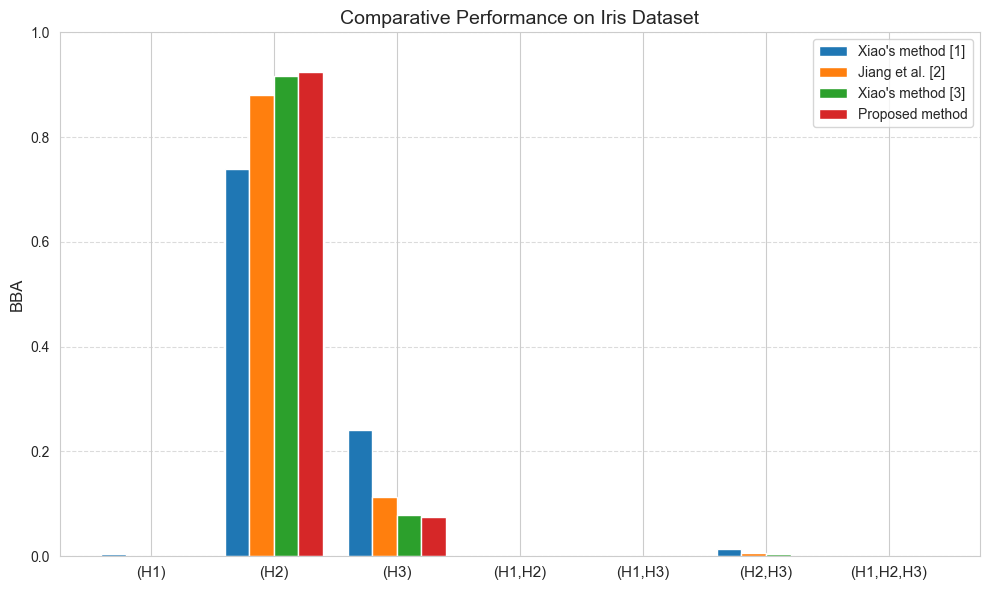

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the LaTeX table
methods = ["Xiao's method [1]", "Jiang et al. [2]", "Xiao's method [3]", "Proposed method"]
data = {
    'm(H₁)': [0.0053, 0.00049, 0.0000688, 0.0000818],
    'm(H₂)': [0.7390, 0.8798, 0.9163, 0.9241],
    'm(H₃)': [0.2407, 0.1130, 0.0790, 0.0757],
    'm(H₁,H₂)': [0.000354, 0.000033, 0.00000459, np.nan],
    'm(H₁,H₃)': [0.000257, 0.0000022, 0.0000026, np.nan],
    'm(H₂,H₃)': [0.0135, 0.0066, 0.0046, np.nan],
    'm(H₁,H₂,H₃)': [0.0000171, 0.0000015, 0.000000173, np.nan]
}

# Prepare the data for plotting
categories = ['(H1)', '(H2)', '(H3)', '(H1,H2)', '(H1,H3)', '(H2,H3)', '(H1,H2,H3)']
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each method's data
for i, method in enumerate(methods):
    offset = width * i
    values = [
        data['m(H₁)'][i],
        data['m(H₂)'][i],
        data['m(H₃)'][i],
        data['m(H₁,H₂)'][i],
        data['m(H₁,H₃)'][i],
        data['m(H₂,H₃)'][i],
        data['m(H₁,H₂,H₃)'][i]
    ]
    # Replace NaN with 0 for plotting
    values = [0 if np.isnan(v) else v for v in values]
    rects = ax.bar(x + offset, values, width, label=method)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BPA', fontsize=12)
ax.set_title('Comparative Performance on Iris Dataset', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(categories, fontsize=11)
ax.legend(fontsize=10)

# Set y-axis to match reference image style
ax.set_ylim(0, 1.0)
ax.set_yticks([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])

# Add grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

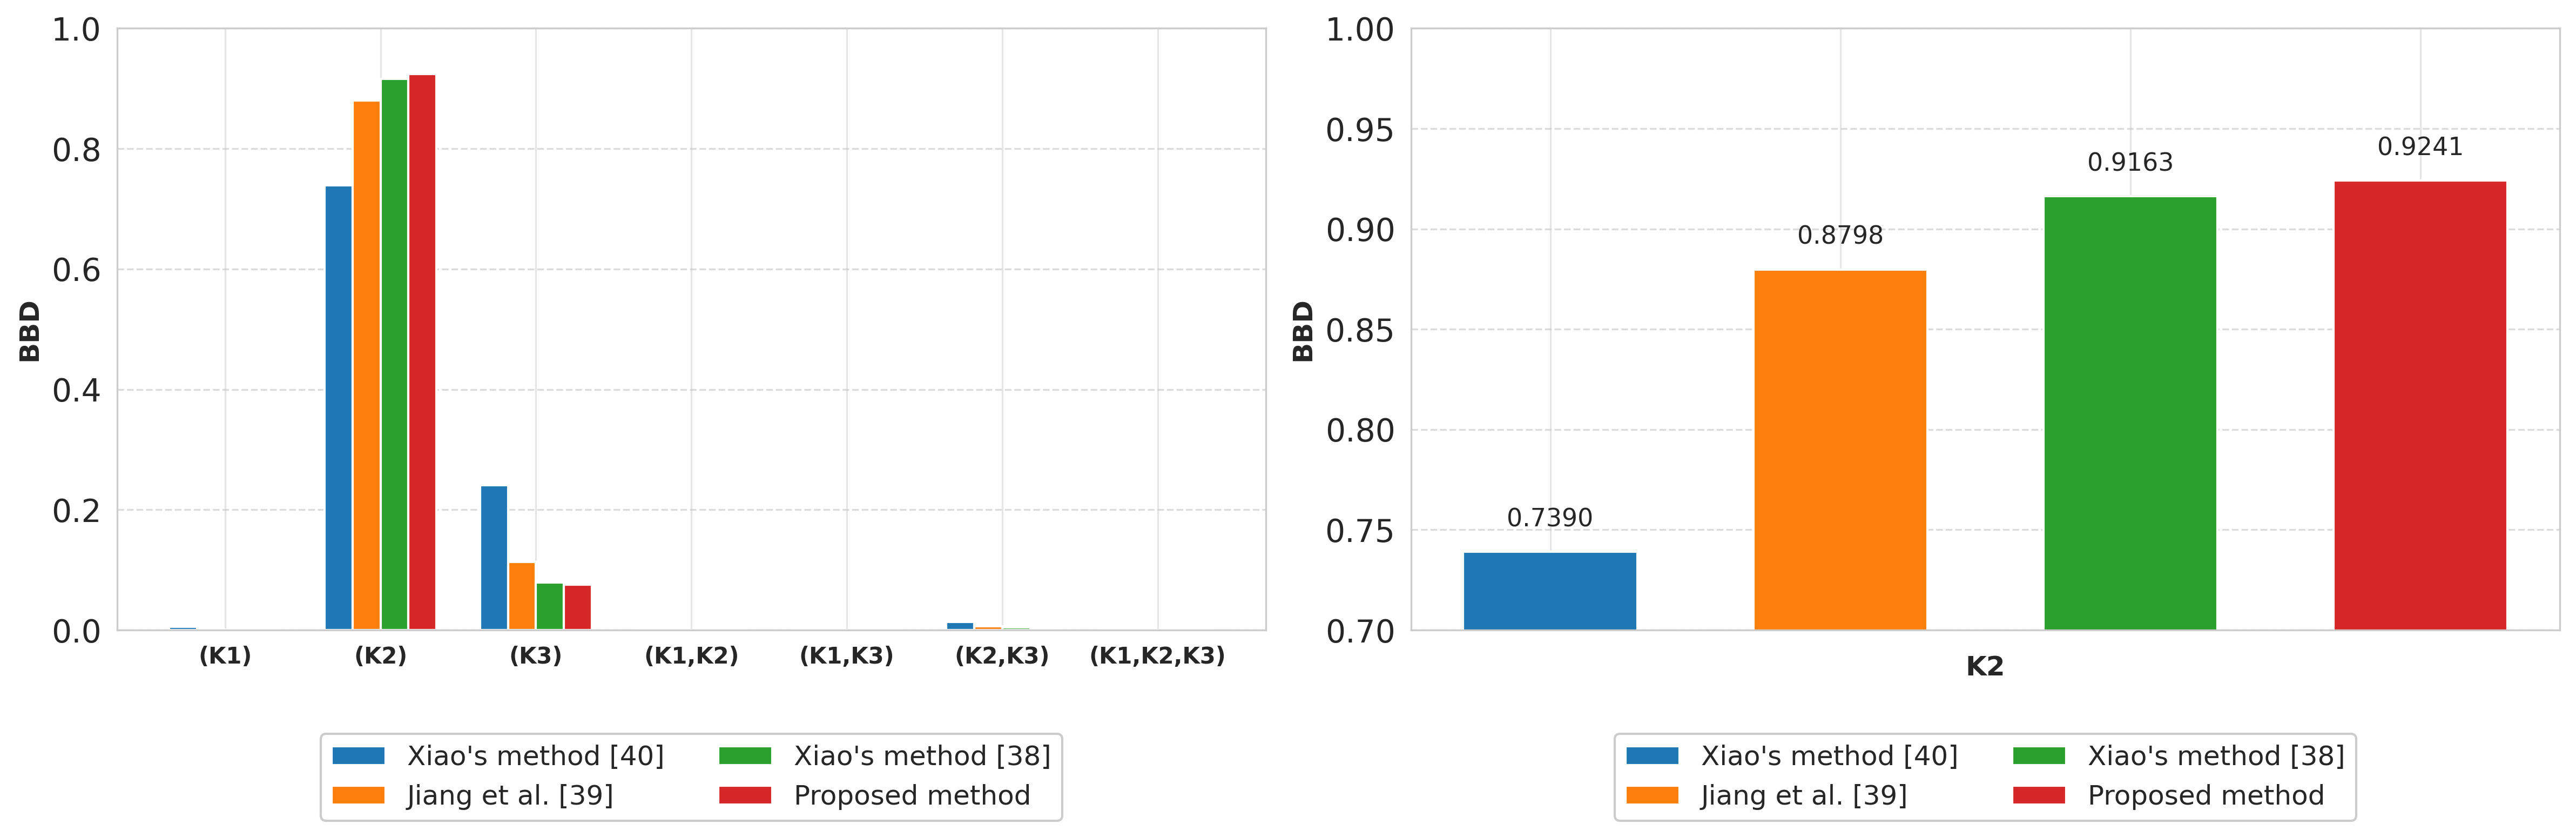

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.3)  # 增加子图间距

# ----------------------------
# 通用设置
# ----------------------------
methods = ["Xiao's method [40]", "Jiang et al. [39]", "Xiao's method [38]", "Proposed method"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 统一颜色方案
legend_params = {
    'fontsize': 12,
    'framealpha': 1,
    'bbox_to_anchor': (0.5, -0.15),
    'loc': 'upper center',
    'ncol': 2
}  # 统一图例参数

# ----------------------------
# First subplot (comparative performance)
# ----------------------------
data = {
    'm(H₁)': [0.0053, 0.00049, 0.0000688, 0.0000818],
    'm(H₂)': [0.7390, 0.8798, 0.9163, 0.9241],
    'm(H₃)': [0.2407, 0.1130, 0.0790, 0.0757],
    'm(H₁,H₂)': [0.000354, 0.000033, 0.00000459, np.nan],
    'm(H₁,H₃)': [0.000257, 0.0000022, 0.0000026, np.nan],
    'm(H₂,H₃)': [0.0135, 0.0066, 0.0046, np.nan],
    'm(H₁,H₂,H₃)': [0.0000171, 0.0000015, 0.000000173, np.nan]
}

# categories = ['(H1)', '(H2)', '(H3)', '(H1,H2)', '(H1,H3)', '(H2,H3)', '(H1,H2,H3)']
categories = ['(K1)', '(K2)', '(K3)', '(K1,K2)', '(K1,K3)', '(K2,K3)', '(K1,K2,K3)']
x = np.arange(len(categories))
width = 0.18  # 稍微减小柱宽

# 绘制第一个子图
for i, (method, color) in enumerate(zip(methods, colors)):
    offset = width * i
    values = [
        data['m(H₁)'][i],
        data['m(H₂)'][i],
        data['m(H₃)'][i],
        data['m(H₁,H₂)'][i],
        data['m(H₁,H₃)'][i],
        data['m(H₂,H₃)'][i],
        data['m(H₁,H₂,H₃)'][i]
    ]
    values = [0 if np.isnan(v) else v for v in values]
    ax1.bar(x + offset, values, width, color=color, label=method)

ax1.set_ylabel('BBD', fontsize=12)
ax1.set_xticks(x + width * 1.5)
# ax1.set_xticklabels(categories, fontsize=10, fontweight='bold', rotation=30, ha='right')
ax1.set_xticklabels(categories, fontsize=10, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.set_yticks([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend(**legend_params)  # 应用统一图例样式

# ----------------------------
# Second subplot (H₂ comparison)
# ----------------------------
bba_values = [0.7390, 0.8798, 0.9163, 0.9241]  # m(H₂) values

# 使用相同的颜色和图例顺序
for method, color, value in zip(methods, colors, bba_values):
    ax2.bar(method, value, color=color, width=0.6, label=method)

# 添加数值标签
for i, (method, value) in enumerate(zip(methods, bba_values)):
    ax2.text(i, value + 0.01, f'{value:.4f}',
            ha='center', va='bottom', fontsize=11)

ax2.set_ylabel('BBD', fontsize=12)
ax2.set_xlabel('K2', fontsize=12)
ax2.set_ylim(0.70, 1.00)
ax2.set_yticks([0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.set_xticklabels([])  # 隐藏x轴原始标签
ax2.legend(**legend_params)  # 应用统一图例样式

# 调整整体布局
plt.tight_layout(rect=[0, 0.1, 1, 1])  # 底部留出空间给图例

plt.savefig("comparison_figure1_new.pdf", bbox_inches='tight', transparent=True)
plt.show()

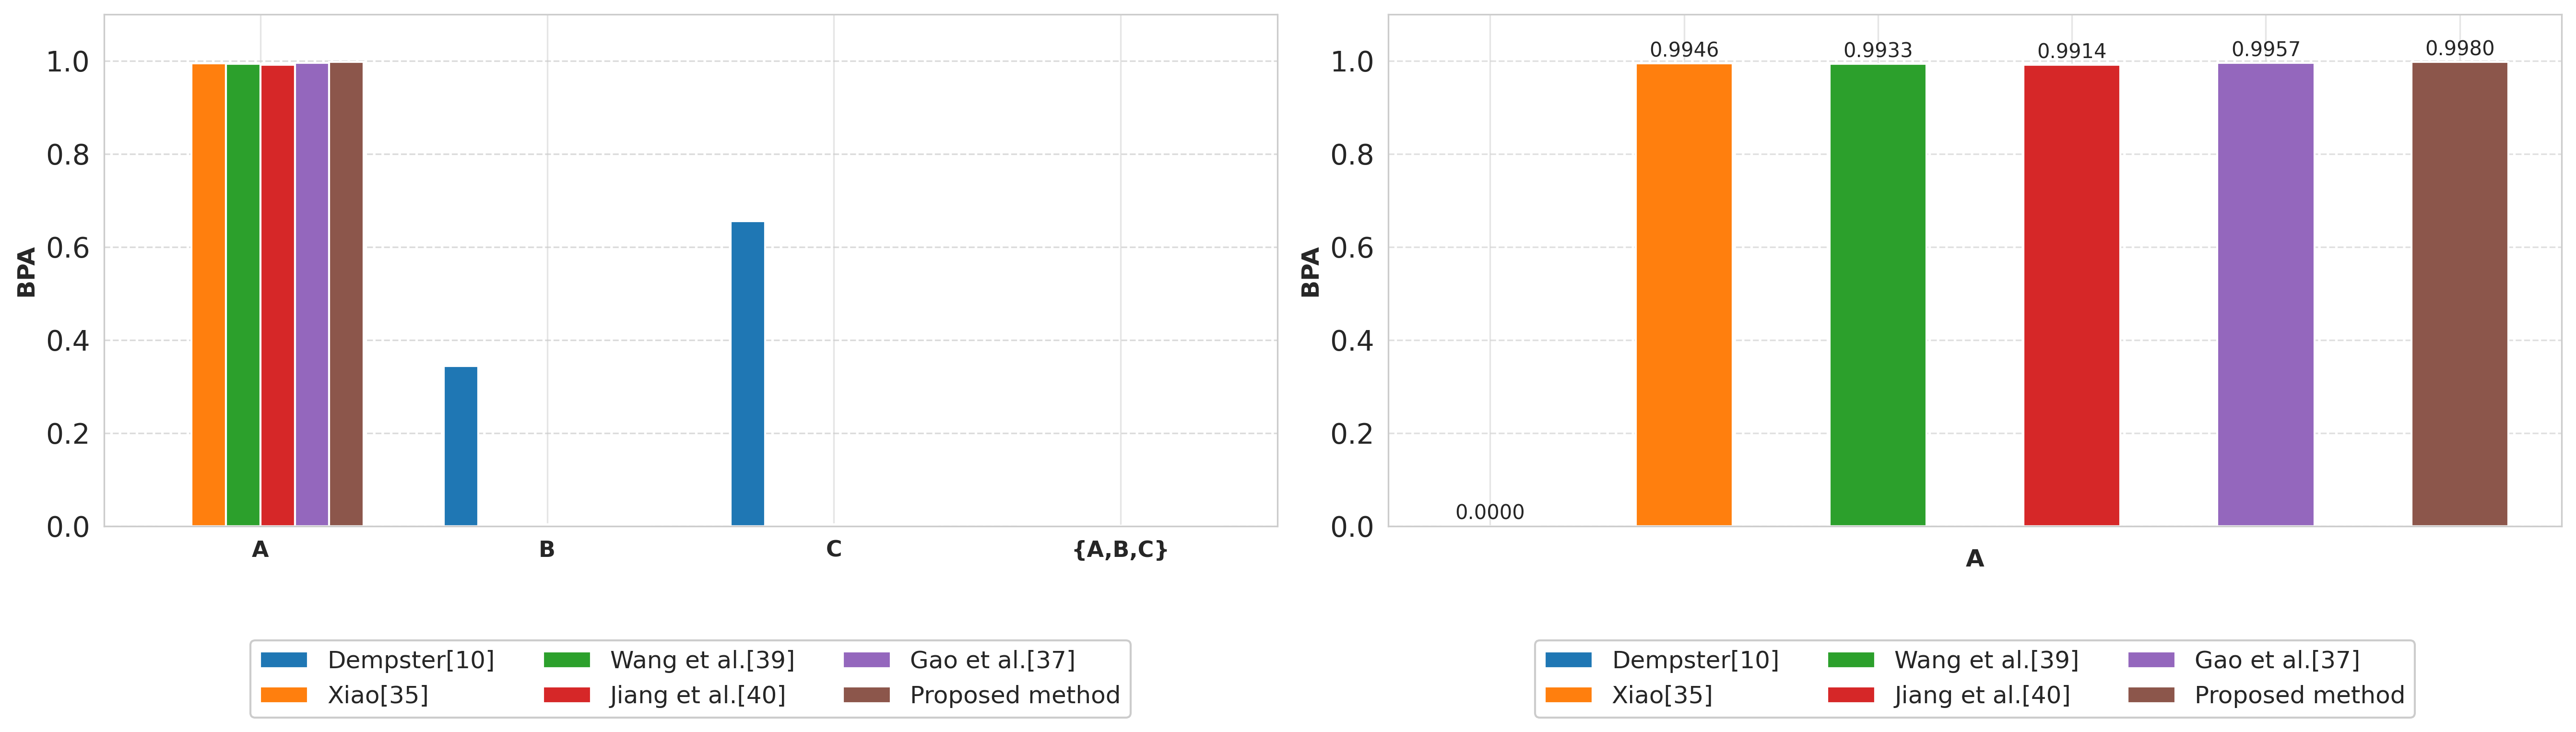

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# 创建包含两个子图的画布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(wspace=0.25)  # 调整子图间距

# ----------------------------
# 通用设置
# ----------------------------
methods = ["Dempster[10]", "Xiao[35]", "Wang et al.[39]", "Jiang et al.[40]", "Gao et al.[37]", "Proposed method"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
legend_params = {
    'fontsize': 12,
    'framealpha': 1,
    'bbox_to_anchor': (0.5, -0.2),  # 统一放在横坐标下方
    'loc': 'upper center',
    'ncol': 3  # 分3列显示更紧凑
}

# ----------------------------
# 第一个子图：综合比较
# ----------------------------
categories = ['A', 'B', 'C', '{A,B,C}']
data = {
    'A': [0, 0.9946, 0.9933, 0.9914, 0.9957, 0.9980],
    'B': [0.3443, 0.0030, 0.0033, 0.0035, 0.0026, 0.0015],
    'C': [0.6557, 0.0015, 0.0025, 0.0042, 0.0008, 0.0003],
    '(A,B,C)': [0, 0.0009, 0.0009, 0.0009, 0.0009, 0.0000]
}

x = np.arange(len(categories))
width = 0.12  # 调整宽度以适应6种方法

# 绘制每种方法的数据
for i, (method, color) in enumerate(zip(methods, colors)):
    offset = width * i
    values = [data['A'][i], data['B'][i], data['C'][i], data['(A,B,C)'][i]]
    ax1.bar(x + offset, values, width, color=color, label=method)

ax1.set_ylabel('BPA', fontsize=12)
ax1.set_xticks(x + width * 2.5)
ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax1.set_ylim(0, 1.1)
ax1.set_yticks([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend(**legend_params)  # 应用统一图例样式

# ----------------------------
# 第二个子图：A值比较
# ----------------------------
bba_values = [0, 0.9946, 0.9933, 0.9914, 0.9957, 0.9980]  # A值数据

# 绘制柱状图（保持与第一个子图相同的颜色顺序）
for method, color, value in zip(methods, colors, bba_values):
    ax2.bar(method, value, color=color, width=0.5, label=method)

# 添加数值标签
for i, (method, value) in enumerate(zip(methods, bba_values)):
    ax2.text(i, value + 0.005, f'{value:.4f}',
            ha='center', va='bottom', fontsize=10)

# 坐标轴和标签设置
ax2.set_ylabel('BPA', fontsize=12)
ax2.set_ylim(0, 1.1)
ax2.set_xticklabels([])
ax2.set_xlabel('A', fontsize=12)
ax2.set_yticks(np.arange(0, 1.1, 0.2))
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.sca(ax2)
plt.xticks(rotation=15, ha='right', fontsize=11)
ax2.legend(**legend_params)  # 应用统一图例样式

# 调整整体布局（为底部图例留出空间）
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig("application2_new.pdf", bbox_inches='tight', transparent=True)
plt.show()

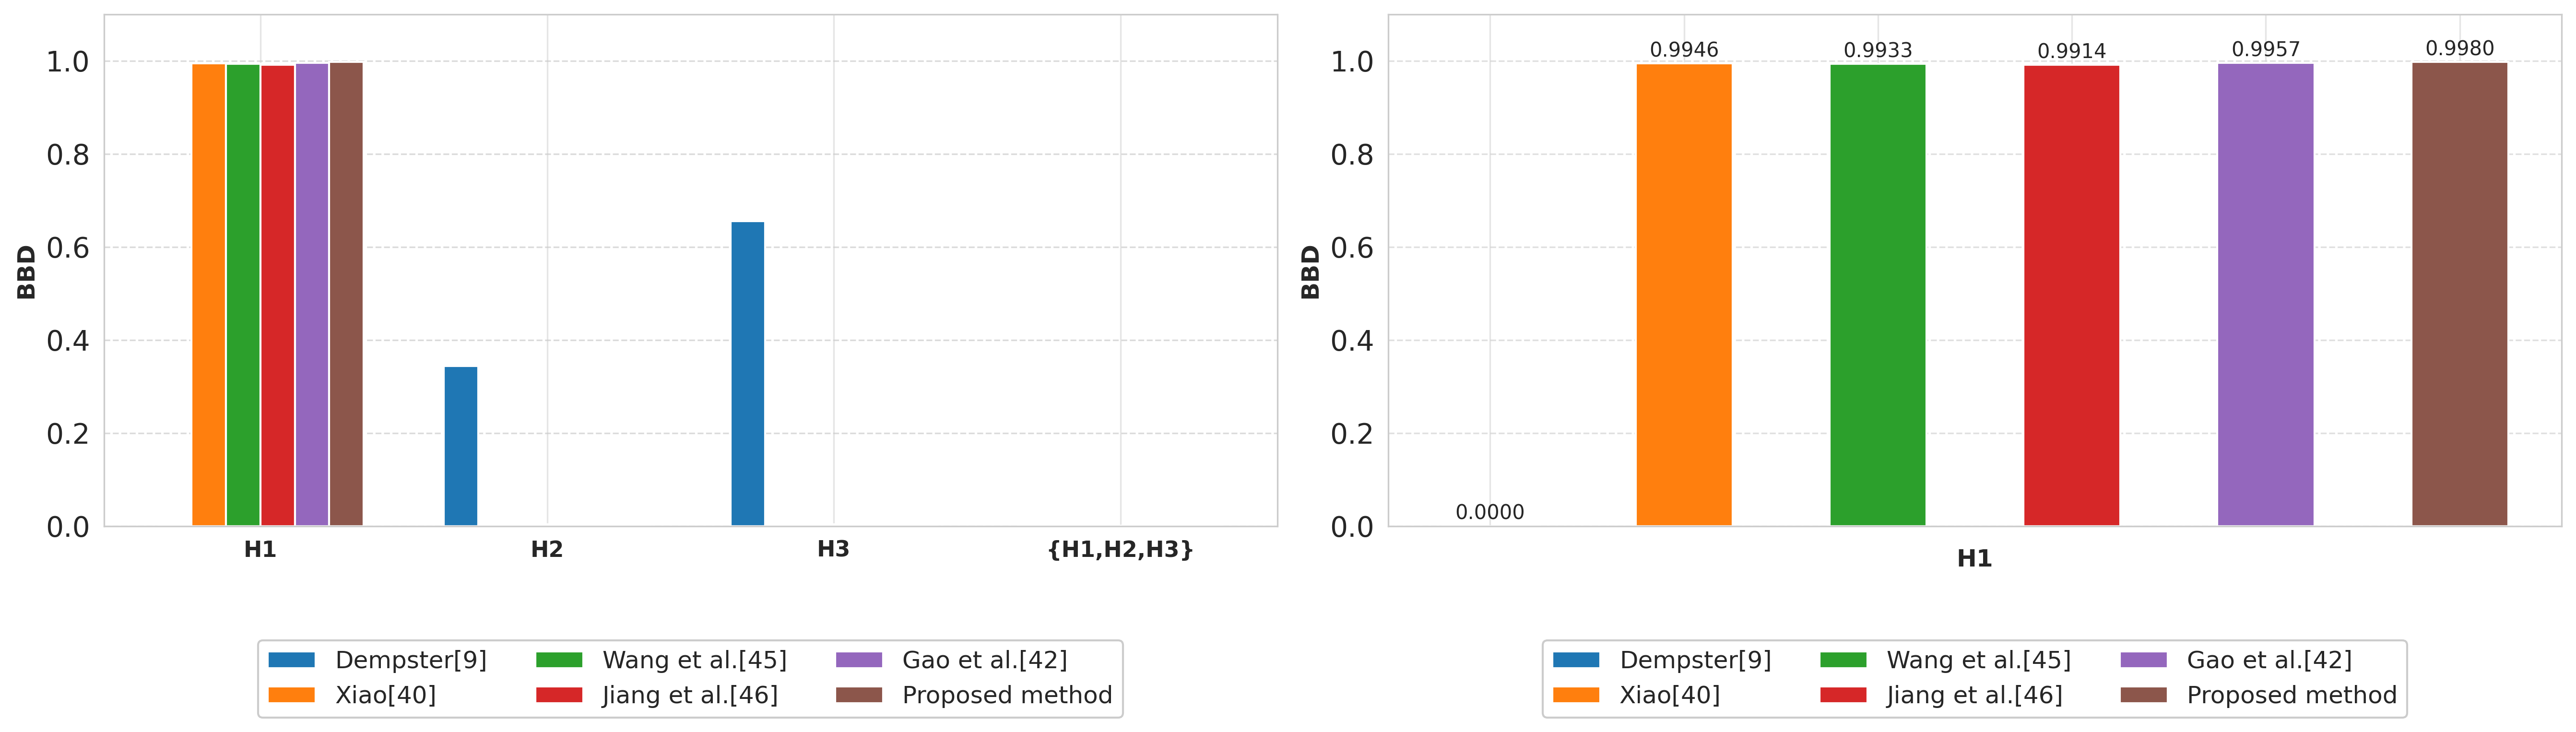

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 创建包含两个子图的画布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(wspace=0.25)  # 调整子图间距

# ----------------------------
# 通用设置
# ----------------------------
methods = ["Dempster[9]", "Xiao[40]", "Wang et al.[45]", "Jiang et al.[46]", "Gao et al.[42]", "Proposed method"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
legend_params = {
    'fontsize': 12,
    'framealpha': 1,
    'bbox_to_anchor': (0.5, -0.2),  # 统一放在横坐标下方
    'loc': 'upper center',
    'ncol': 3  # 分3列显示更紧凑
}

# ----------------------------
# 第一个子图：综合比较
# ----------------------------
categories = ['H1', 'H2', 'H3', '{H1,H2,H3}']
data = {
    'H1': [0, 0.9946, 0.9933, 0.9914, 0.9957, 0.9980],
    'H2': [0.3443, 0.0030, 0.0033, 0.0035, 0.0026, 0.0015],
    'H3': [0.6557, 0.0015, 0.0025, 0.0042, 0.0008, 0.0003],
    '(H1,H2,H3)': [0, 0.0009, 0.0009, 0.0009, 0.0009, 0.0000]
}

x = np.arange(len(categories))
width = 0.12  # 调整宽度以适应6种方法

# 绘制每种方法的数据
for i, (method, color) in enumerate(zip(methods, colors)):
    offset = width * i
    values = [data['H1'][i], data['H2'][i], data['H3'][i], data['(H1,H2,H3)'][i]]
    ax1.bar(x + offset, values, width, color=color, label=method)

ax1.set_ylabel('BBD', fontsize=12)
ax1.set_xticks(x + width * 2.5)
ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax1.set_ylim(0, 1.1)
ax1.set_yticks([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend(**legend_params)  # 应用统一图例样式

# ----------------------------
# 第二个子图：H1值比较
# ----------------------------
bba_values = [0, 0.9946, 0.9933, 0.9914, 0.9957, 0.9980]  # H1值数据

# 绘制柱状图（保持与第一个子图相同的颜色顺序）
for method, color, value in zip(methods, colors, bba_values):
    ax2.bar(method, value, color=color, width=0.5, label=method)

# 添加数值标签
for i, (method, value) in enumerate(zip(methods, bba_values)):
    ax2.text(i, value + 0.005, f'{value:.4f}',
            ha='center', va='bottom', fontsize=10)

# 坐标轴和标签设置
ax2.set_ylabel('BBD', fontsize=12)
ax2.set_ylim(0, 1.1)
ax2.set_xticklabels([])
ax2.set_xlabel('H1', fontsize=12)
ax2.set_yticks(np.arange(0, 1.1, 0.2))
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.sca(ax2)
plt.xticks(rotation=15, ha='right', fontsize=11)
ax2.legend(**legend_params)  # 应用统一图例样式

# 调整整体布局（为底部图例留出空间）
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig("application2_BBD.pdf", bbox_inches='tight', transparent=True)
plt.show()

## 11.1 目标B和C的对比

In [ ]:
# 生成数据缺失场景下的实验数据
def generate_missing_data(x_values, missing_rate=0.2):
    evidence_list = []
    for x in x_values:
        evidence = [
            {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},  # 传感器1
            {('A',): 0.95 - x, ('B',): 0.05, ('C',): x},  # 传感器2（受干扰）
            {('A',): 0.9, ('B',): 0.05, ('C',): 0.05}  # 传感器3
        ]

        # 随机删除部分数据
        # for i in range(len(evidence)):
        #     if np.random.rand() < missing_rate:
        #         evidence[i] = {}  # 删除该传感器的数据

        evidence_list.append(evidence)
    return evidence_list

# 设置干扰强度范围
x_values = np.linspace(0, 0.95, 100)  # 从0到0.95，生成11个干扰强度
evidence_list = generate_missing_data(x_values, missing_rate=0.2)
results = []

# 打印生成的实验数据
for i, evidence in enumerate(evidence_list):
    # print(f"Interference x = {x_values[i]:.2f}: Evidence = {evidence}")
    normalized_evidence = normalize_evidence(evidence)
    S = compute_similarity_matrix(normalized_evidence)
    R = new_compute_weight_from_similarity_gaussian(S)
    fused_probabilities = fuse_evidence(normalized_evidence, R, alpha=0.1)

    results.append((x_values[i], fused_probabilities))

# 初始化三个数组来存储 A、B、C 的概率
prob_A = []
prob_B = []
prob_C = []

# 遍历结果，提取 A、B、C 的概率
for x, fused in results:
    prob_A.append(fused.get('A', 0))  # 如果 'A' 不存在，默认值为 0
    prob_B.append(fused.get('B', 0))  # 如果 'B' 不存在，默认值为 0
    prob_C.append(fused.get('C', 0))  # 如果 'C' 不存在，默认值为 0

# 计算均值和方差
mean_A = np.mean(prob_A)
variance_A = np.var(prob_A)

mean_B = np.mean(prob_B)
variance_B = np.var(prob_B)

mean_C = np.mean(prob_C)
variance_C = np.var(prob_C)


print(f"Target H1 (A): Mean = {mean_A:.6f}, Variance = {variance_A:.6f}")
print(f"Target H2 (B): Mean = {mean_B:.6f}, Variance = {variance_B:.6f}")
print(f"Target H3 (C): Mean = {mean_C:.6f}, Variance = {variance_C:.6f}")

# 绘制目标 H2 和 H3 的识别概率分布
plt.figure(figsize=(10, 6))
# plt.hist(prob_A, bins=20, alpha=0.7, label='Target H2 (A)')
plt.hist(prob_B, bins=20, alpha=0.7, label='Target x1')
plt.hist(prob_C, bins=20, alpha=0.7, label='Target x2')
plt.title('Recognition Probability Distribution of Targets x1 and x2', fontsize=16)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 10.2 目标A的显示

In [ ]:
# 生成数据缺失场景下的实验数据
def generate_missing_data(x_values, missing_rate=0.2):
    evidence_list = []
    for x in x_values:
        evidence = [
            {('A',): 0.9, ('B',): 0.05, ('C',): 0.05},  # 传感器1
            {('A',): 0.95 - x, ('B',): 0.05, ('C',): x},  # 传感器2（受干扰）
            {('A',): 0.9, ('B',): 0.05, ('C',): 0.05}  # 传感器3
        ]

        # 随机删除部分数据
        # for i in range(len(evidence)):
        #     if np.random.rand() < missing_rate:
        #         evidence[i] = {}  # 删除该传感器的数据

        evidence_list.append(evidence)
    return evidence_list

# 设置干扰强度范围
x_values = np.linspace(0, 0.95, 100)  # 从0到0.95，生成11个干扰强度
evidence_list = generate_missing_data(x_values, missing_rate=0.2)
results = []

# 打印生成的实验数据
for i, evidence in enumerate(evidence_list):
    # print(f"Interference x = {x_values[i]:.2f}: Evidence = {evidence}")
    normalized_evidence = normalize_evidence(evidence)
    S = compute_similarity_matrix(normalized_evidence)
    R = new_compute_weight_from_similarity_gaussian(S)
    fused_probabilities = fuse_evidence(normalized_evidence, R, alpha=0.1)

    results.append((x_values[i], fused_probabilities))

# 初始化三个数组来存储 A、B、C 的概率
prob_A = []
prob_B = []
prob_C = []

# 遍历结果，提取 A、B、C 的概率
for x, fused in results:
    print(f"Interference x = {x:.2f}: Fused probabilities = {fused}")
    prob_A.append(fused.get('A', 0))  # 如果 'A' 不存在，默认值为 0
    prob_B.append(fused.get('B', 0))  # 如果 'B' 不存在，默认值为 0
    prob_C.append(fused.get('C', 0))  # 如果 'C' 不存在，默认值为 0

# 计算均值和方差
mean_A = np.mean(prob_A)
variance_A = np.var(prob_A)

mean_B = np.mean(prob_B)
variance_B = np.var(prob_B)

mean_C = np.mean(prob_C)
variance_C = np.var(prob_C)


print(f"Target H1 (A): Mean = {mean_A:.6f}, Variance = {variance_A:.6f}")
print(f"Target H2 (B): Mean = {mean_B:.6f}, Variance = {variance_B:.6f}")
print(f"Target H3 (C): Mean = {mean_C:.6f}, Variance = {variance_C:.6f}")

# 绘制目标 A 的识别概率分布
plt.figure(figsize=(10, 6))
plt.plot(x_values, prob_A, label='Target x1', color='blue', linewidth=2)

# 设置标题和标签
plt.title('Recognition Probability Distribution of Target x1', fontsize=16)
plt.xlabel('Interference Strength (x)', fontsize=14)
plt.ylabel('Probability', fontsize=14)

# 设置 X 轴范围和刻度
plt.xlim(0, 0.95)  # X 轴范围从 0 到 0.95
plt.xticks(np.arange(0, 1.0, 0.05))  # X 轴刻度间隔为 0.1

# 设置 Y 轴范围和刻度
plt.ylim(0.99, 1.001)  # Y 轴范围从 0.99 到 1.001
plt.yticks(np.arange(0.99, 1.001, 0.002))  # Y 轴刻度间隔为 0.002

# 添加图例
plt.legend(fontsize=12)

# 设置网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图表
plt.show()

# 12 isir数据转化为BPA

In [61]:
import numpy as np
import pandas as pd
from itertools import chain, combinations
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# 1. 载入鸢尾花数据集
iris = load_iris()
X = iris.data
y = iris.target
target_mapping = {'Setosa': 'A', 'Versicolor': 'B', 'Virginica': 'C'}
target_names = ['A', 'B', 'C']  # 重新定义类别名称

# 2. 计算类别中心
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_centers = {i: X_train[y_train == i].mean(axis=0) for i in np.unique(y_train)}

# 3. 生成完整的幂集（包括组合类别）
def get_full_powerset(categories):
    """生成完整幂集（不包括空集）"""
    return [set(p) for p in chain.from_iterable(combinations(categories, r) for r in range(1, len(categories) + 1))]

powerset = get_full_powerset(target_names)  # 计算所有组合命题

# 4. 计算 BPA 并分配到完整幂集
def compute_bpa(sample, centers, alpha=0.1, beta=0.2):
    """
    计算样本的基本概率指派（BPA）
    alpha: 分配给全集的BPA
    beta: 组合命题的最大BPA比例
    """
    distances = {i: np.linalg.norm(sample - center) for i, center in centers.items()}

    # 计算反距离
    inv_distances = {i: 1.0 / d if d > 0 else 1e6 for i, d in distances.items()}  # 避免除零
    total_inv_dist = sum(inv_distances.values())

    # 计算单类别 BPA
    bpa = {frozenset([target_names[i]]): inv_distances[i] / total_inv_dist * (1 - alpha - beta) for i in inv_distances}

    # 计算组合类别 BPA
    sorted_dist = sorted(distances.items(), key=lambda x: x[1])  # 按距离排序
    primary, secondary, tertiary = sorted_dist[0][0], sorted_dist[1][0], sorted_dist[2][0]

    # 计算组合命题 BPA
    bpa[frozenset([target_names[primary], target_names[secondary]])] = beta * 0.6
    bpa[frozenset([target_names[primary], target_names[tertiary]])] = beta * 0.3
    bpa[frozenset([target_names[secondary], target_names[tertiary]])] = beta * 0.1

    # 计算全集 BPA
    bpa[frozenset(target_names)] = alpha

    return bpa

# 5. 计算所有测试样本的 BPA
bpa_list = [compute_bpa(sample, class_centers) for sample in X_test]

# 6. 转换为目标格式
evidence = []
for bpa in bpa_list:
    # 将 frozenset 转换为元组，并保留键值对
    formatted_bpa = {tuple(k): v for k, v in bpa.items()}
    evidence.append(formatted_bpa)

# 打印前 2 个证据体
# print(evidence[:2])
normalized_evidence = normalize_evidence(evidence)
S = compute_similarity_matrix_jousselme(normalized_evidence)
R = new_compute_weight_from_similarity_nonlinear(S)
fused_probabilities = fuse_evidence(normalized_evidence, R, alpha=0.1)

print("Optimal R:", R)
print("Fused probabilities (after SLF):", fused_probabilities)

Optimal R: [0.0355825  0.03058331 0.04926022 0.02815407 0.04869947 0.02680758
 0.03662534 0.04253866 0.03990637 0.02547996 0.04069549 0.02736095
 0.02771858 0.02470478 0.02392532 0.04570657 0.02794028 0.03262729
 0.02552791 0.02726062 0.02550822 0.04754636 0.01870934 0.02432805
 0.04961336 0.0371973  0.03980327 0.03686931 0.02722848 0.02609106]
Fused probabilities (after SLF): {'A': 0.05747292884571634, 'B': 0.14909900313562713, 'C': 0.7934110044561309}


In [73]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 加载Iris数据集
iris = load_iris()
X = iris.data  # 特征矩阵
y = iris.target  # 类别标签

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义类别
classes = {'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}

# 训练随机森林模型，每个特征单独训练一个模型
def train_models(X_train, y_train):
    models = {}
    for i in range(X_train.shape[1]):  # 遍历每个特征
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train[:, i].reshape(-1, 1), y_train)  # 仅使用当前特征训练模型
        models[i] = model
    return models

# 训练模型
models = train_models(X_train, y_train)

# 计算每个特征的BBA（证据体）
def calculate_bba(models, x):
    bba = {}
    for i, model in models.items():  # 遍历每个特征对应的模型
        probs = model.predict_proba(x[i].reshape(1, -1))[0]  # 预测概率分布
        bba[i] = {cls: prob for cls, prob in zip(classes.keys(), probs)}  # 转换为BBA格式
    return bba

# 示例：计算测试集中第一个样本的BBA
sample_index = 0
x_sample = X_test[sample_index]
bba_sample = calculate_bba(models, x_sample)

# 输出结果
print(f"Test sample values: {x_sample}")
print(f"BBA for sample {sample_index}:")
for feature_idx, bba in bba_sample.items():
    print(f"Feature {feature_idx} (Sepal Length/Sepal Width/Petal Length/Petal Width): {bba}")

# 检查模型训练效果
for i, model in models.items():
    print(f"Feature {i} accuracy: {model.score(X_train[:, i].reshape(-1, 1), y_train)}")

Test sample values: [6.1 2.8 4.7 1.2]
BBA for sample 0:
Feature 0 (Sepal Length/Sepal Width/Petal Length/Petal Width): {'Setosa': 0.0, 'Versicolor': 0.7524523809523807, 'Virginica': 0.24754761904761896}
Feature 1 (Sepal Length/Sepal Width/Petal Length/Petal Width): {'Setosa': 0.0, 'Versicolor': 0.32958634421134425, 'Virginica': 0.670413655788656}
Feature 2 (Sepal Length/Sepal Width/Petal Length/Petal Width): {'Setosa': 0.0, 'Versicolor': 1.0, 'Virginica': 0.0}
Feature 3 (Sepal Length/Sepal Width/Petal Length/Petal Width): {'Setosa': 0.0, 'Versicolor': 1.0, 'Virginica': 0.0}
Feature 0 accuracy: 0.7714285714285715
Feature 1 accuracy: 0.6190476190476191
Feature 2 accuracy: 0.9428571428571428
Feature 3 accuracy: 0.9428571428571428


In [116]:
import numpy as np

def adjust_evidence_bodies(soft_likelihoods):
    """
    调整平均证据体 (Step 3-1)
    - 输入: soft_likelihoods (字典), 键为命题，值为软似然函数值。
    - 输出: 调整后的证据体 (字典)。
    """
    total = sum(soft_likelihoods.values())
    adjusted_evidence = {proposition: likelihood / total for proposition, likelihood in soft_likelihoods.items()}
    return adjusted_evidence

def dempster_combine(m1, m2):
    """
    Dempster 组合规则 (DCR)
    - 输入: m1 和 m2 是两个证据体的字典表示。
    - 输出: 融合后的证据体 (字典)。
    """
    hypotheses = set(m1.keys()).union(set(m2.keys()))
    m_combined = {h: 0.0 for h in hypotheses}

    # 计算冲突因子 K
    K = 0.0
    for h1, h2 in [(h1, h2) for h1 in m1 for h2 in m2]:
        if set(h1).isdisjoint(set(h2)):  # 如果 h1 和 h2 不相交
            K += m1[h1] * m2[h2]

    # 计算组合后的 BPA
    for h1, h2 in [(h1, h2) for h1 in m1 for h2 in m2]:
        intersection = set(h1).intersection(set(h2))
        if intersection:  # 如果 h1 和 h2 有交集
            key = tuple(sorted(intersection))
            m_combined[key] += m1[h1] * m2[h2] / (1 - K)

    return m_combined

def fuse_evidence_multiple_times(adjusted_evidence, n):
    """
    多次融合证据 (Step 3-2)
    - 输入: adjusted_evidence (字典), 调整后的证据体。
    - 输入: n (整数), 融合次数。
    - 输出: 最终融合结果 (字典)。
    """
    result = adjusted_evidence
    for _ in range(n - 1):
        result = dempster_combine(result, adjusted_evidence)
    return result

# 示例使用
if __name__ == "__main__":
    # 定义软似然函数值
    soft_likelihoods = {
        ('A',): 0.2,
        ('B',): 0.5,
        ('C',): 0.3
    }

    # Step 3-1: 调整平均证据体
    adjusted_evidence = adjust_evidence_bodies(soft_likelihoods)
    print("Adjusted Evidence Bodies:", adjusted_evidence)

    # Step 3-2: 多次融合证据
    n = 3  # 融合次数
    fused_result = fuse_evidence_multiple_times(adjusted_evidence, n)
    print("Fused Result (after", n, "fusions):", fused_result)

Adjusted Evidence Bodies: {('A',): 0.2, ('B',): 0.5, ('C',): 0.3}
Fused Result (after 3 fusions): {('A',): 0.05000000000000002, ('B',): 0.7812500000000001, ('C',): 0.16875}


# 已有论文中的实验总结

## 肖老师的论文里：实验部分引用了一个别的论文数据，然后解析实验步骤结果，最后有个对比；在application部分引用了别的论文的数据集，然后有对比

## 康老师的实验部分设计了一个实验，来说明抗干扰性，说明算法同样可以；但是多了一个案例部分，在这个部分也是自己设计的数据，但是也是有对比的；在application部分引用了别的论文里的案例，他想说明他的融合在第三次就很能识别了。

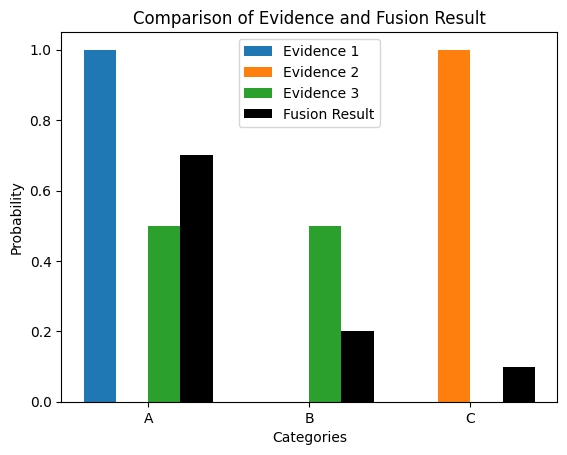

In [189]:
import numpy as np
import matplotlib.pyplot as plt

categories = ['A', 'B', 'C']
evidence_1 = [1.0, 0.0, 0.0]  # 完全支持 A
evidence_2 = [0.0, 0.0, 1.0]  # 完全支持 C
evidence_3 = [0.5, 0.5, 0.0]  # 对 A 和 B 各占一半
fusion_result = [0.7, 0.2, 0.1]  # 融合后的结果（假设）

x = np.arange(len(categories))
width = 0.2  # 柱状图宽度

fig, ax = plt.subplots()
ax.bar(x - 1.5*width, evidence_1, width, label='Evidence 1')
ax.bar(x - 0.5*width, evidence_2, width, label='Evidence 2')
ax.bar(x + 0.5*width, evidence_3, width, label='Evidence 3')
ax.bar(x + 1.5*width, fusion_result, width, label='Fusion Result', color='black')

ax.set_xlabel('Categories')
ax.set_ylabel('Probability')
ax.set_title('Comparison of Evidence and Fusion Result')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.show()

In [ ]:
def product_weight_fusion(w_sim, w_conf):
    w_product = w_sim * w_conf
    return w_product / np.sum(w_product)

# 示例使用
w_combined = product_weight_fusion(w_sim, w_conf)
print("综合权重:", w_combined)